# Import Libraries and Data

In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#!pip install pybart
from pybart.api import BART
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#!pip install xgboost
from xgboost import XGBRegressor
#!pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS, RFE

# Reset Plot Settings
plt.rcdefaults()

In [457]:
df = pd.read_csv('austinhouses.csv')
df_holdout = pd.read_csv('austinhouses_holdout.csv')

## Printing First 5 Rows of the Data

In [459]:
df.head()

,streetAddress,zipcode,description,latitude,longitude,garageSpaces,hasAssociation,hasGarage,hasSpa,hasView,...,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
0,14004 Chisos Trl,78717,"COVETED, SPACIOUS 3 bed + OFFICE, 1story MIL P...",30.495638,-97.797874,0,True,False,False,False,...,0,7666.0,2228,1.900000,8.333333,1481,16,2.0,3,1
1,14405 Laurinburg Dr,78717,Popular Bingham Floor plan in sought after Nor...,30.488775,-97.794899,2,True,True,False,False,...,0,8494.0,3494,3.300000,7.666667,1259,14,5.0,4,2
2,14702 Menifee St,78725,"Fridge, washer, dryer, wall tv mounts do not c...",30.233154,-97.587318,2,False,True,False,False,...,0,5183.0,1534,1.800000,3.000000,1457,13,3.0,3,1
3,15207 Lucian St,78725,Don't miss this opportunity to find a great ho...,30.238237,-97.578331,2,True,True,False,False,...,0,8145.0,1652,1.966667,3.000000,1457,13,2.0,3,1
4,12525 Verandah Ct,78726,Welcome to the Estates of Grandview Hills. Th...,30.426456,-97.859291,2,True,True,False,True,...,0,30056.4,3402,2.066667,7.000000,1277,16,4.0,4,2


# Data Pre-Processing

First, per the instructions, we will not be using the street address and description as predictors. So, I drop them from the data sets below.

In [462]:
df.drop(columns = ['streetAddress','description'], inplace = True)
df_holdout.drop(columns = ['streetAddress','description'], inplace = True)

## 1: Verifying each variable's viability as a predictor and indicating how the preferred data type for modeling.

In [464]:
df.columns

Index(['zipcode', 'latitude', 'longitude', 'garageSpaces', 'hasAssociation',
       'hasGarage', 'hasSpa', 'hasView', 'homeType', 'yearBuilt',
       'latestPrice', 'latest_saledate', 'latest_salemonth', 'latest_saleyear',
       'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories'],
      dtype='object')

In [465]:
df.dtypes

zipcode                         int64
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasAssociation                   bool
hasGarage                        bool
hasSpa                           bool
hasView                          bool
homeType                       object
yearBuilt                       int64
latestPrice                   float64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfAppliances                 int64
numOfParkingFeatures            int64
numOfPatioAndPorchFeatures      int64
numOfSecurityFeatures           int64
numOfWaterfrontFeatures         int64
numOfWindowFeatures             int64
numOfCommunityFeatures          int64
lotSizeSqFt                   float64
livingAreaSqFt                  int64
avgSchoolDistance             float64
avgSchoolRat

In [466]:
# Getting the unique values of every column in the dataset.
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique values: {unique_values}")
    print("-" * 50)

Column: zipcode
Unique values: [78717 78725 78726 78744 78729 78724 78732 78750 78731 78746 78735 78733
 78730 78734 78737 78739 78759 78758 78753 78728 78754 78736 78747 78757
 78727 78745 78704 78741 78742 78749 78748 78738 78702 78703 78705 78722
 78723 78721 78653 78751 78752 78756]
--------------------------------------------------
Column: latitude
Unique values: [30.49563789 30.48877525 30.2331543  ... 30.16199684 30.24022293
 30.2448349 ]
--------------------------------------------------
Column: longitude
Unique values: [-97.79787445 -97.79489899 -97.58731842 ... -97.81634521 -97.77283478
 -97.76112366]
--------------------------------------------------
Column: garageSpaces
Unique values: [ 0  2  1  6  4  3  9  5 10  8 12  7]
--------------------------------------------------
Column: hasAssociation
Unique values: [ True False]
--------------------------------------------------
Column: hasGarage
Unique values: [False  True]
--------------------------------------------------
Colu

**Intuitively, this is my analysis on the predictors:**

zipcode
- Include: Yes, it captures location-specific factors influencing housing prices.
- Data Type: Categorical (need to change)

latitude
- Include: Yes, precise location influences prices.
- Data Type: Numerical

longitude
- Include: Yes, precise location influences prices.
- Data Type: Numerical
  
garageSpaces
- Include: Yes, the number of garage spaces can influence prices.
- Data Type: Numerical

hasAssociation
- Include: Yes, presence of an association may indicate additional amenities or fees.
- Data Type: Categorical (binary) (need to change)

hasGarage
- Include: Yes, presence of a garage can influence prices.
- Data Type: Categorical (binary) (need to change)

hasSpa
- Include: Yes, presence of a spa can add value to a property.
- Data Type: Categorical (binary) (need to change)
  
hasView
- Include: Yes, having a view is a significant factor in property valuation.
- Data Type: Categorical (binary) (need to change)

homeType
- Include: No, while different home types have different price ranges, the data set only has Single Family homes.

yearBuilt
- Include: Yes, the age of the property can influence prices.
- Data Type: Numerical

latestPrice
- Include: No, this is the target variable.

latest_saledate
- Include: No, unless treating the data from a time series perspective. This is too granular. 

latest_salemonth
- Include: Yes, could capture seasonal trends in pricing.
- Data Type: Categorical (need to change)

latest_saleyear
- Include: Yes, could capture long-term trends in pricing.
- Data Type: Numerical

numOfPhotos
- Include: Yes, more photos might indicate a better marketing effort and higher prices.
- Data Type: Numerical

numOfAccessibilityFeatures
- Include: Yes, accessibility features can influence prices.
- Data Type: Numerical

numOfAppliances
- Include: Yes, more appliances might indicate a well-equipped home.
- Data Type: Numerical

numOfParkingFeatures
- Include: Yes, parking features can add value to a property.
- Data Type: Numerical

numOfPatioAndPorchFeatures
- Include: Yes, outdoor features can add value to a property.
- Data Type: Numerical

numOfSecurityFeatures
- Include: Yes, security features can add value to a property.
- Data Type: Numerical

numOfWaterfrontFeatures
- Include: Yes, waterfront features can add significant value.
- Data Type: Numerical

numOfWindowFeatures
- Include: Yes, window features can add value to a property.
- Data Type: Numerical

numOfCommunityFeatures
- Include: Yes, community features can influence property values.
- Data Type: Numerical

lotSizeSqFt
- Include: Yes, lot size is a crucial factor in property valuation.
- Data Type: Numerical

livingAreaSqFt
- Include: Yes, living area size is a key factor in property valuation.
- Data Type: Numerical

avgSchoolDistance
- Include: Yes, proximity to schools can influence prices.
- Data Type: Numerical

avgSchoolRating
- Include: Yes, better school ratings can increase property values.
- Data Type: Numerical

avgSchoolSize
- Include: Yes, school size might correlate with quality or desirability.
- Data Type: Numerical

MedianStudentsPerTeacher
- Include: Yes, lower ratios often indicate better schools.
- Data Type: Numerical

numOfBathrooms
- Include: Yes, the number of bathrooms is a critical factor in property valuation.
- Data Type: Numerical

numOfBedrooms
- Include: Yes, the number of bedrooms is a critical factor in property valuation.
- Data Type: Numerical

numOfStories
- Include: Yes, the number of stories can influence property values.
- Data Type: Numerical

Another way to decide on which variables to include as predictors would also be to use a correlation matrix to determine which numerical features are relevant to the target variable. Depending on my intiial model results, I may pursue this option during feature selection.

Additionally, in regards to transforming any variables, since there are many Austin zip codes that would greatly expand the dimensionality of the data set upon being dummy encoded, I believe it would be best to aggregate them into broader regions.

The code below applies the changes specified to the data sets!

In [470]:
def aggregate_zipcode(zipcode):
    if 78701 <= zipcode <= 78705:
        return 'Central Austin'
    elif 78721 <= zipcode <= 78725:
        return 'East Austin'
    elif 78731 <= zipcode <= 78735:
        return 'West Austin'
    elif 78741 <= zipcode <= 78747:
        return 'South Austin'
    elif 78750 <= zipcode <= 78759:
        return 'North Austin'
    else:
        return 'Other'

df['zipcode_aggregated'] = df['zipcode'].apply(aggregate_zipcode)
df = df.drop(columns=['zipcode','homeType','latest_saledate'])

df['hasAssociation'] = df['hasAssociation'].astype('category')
df['hasGarage'] = df['hasGarage'].astype('category')
df['hasSpa'] = df['hasSpa'].astype('category')
df['hasView'] = df['hasView'].astype('category')
df['latest_salemonth'] = df['latest_salemonth'].astype('category')
df['zipcode_aggregated'] = df['zipcode_aggregated'].astype('category')

df = pd.get_dummies(df, drop_first=True) # avoid multicolinearity
# if all booleans are 0 for latest_salemonth or zipcode, it is January and Central Austin respectively

In [471]:
print(df.dtypes)

latitude                           float64
longitude                          float64
garageSpaces                         int64
yearBuilt                            int64
latestPrice                        float64
latest_saleyear                      int64
numOfPhotos                          int64
numOfAccessibilityFeatures           int64
numOfAppliances                      int64
numOfParkingFeatures                 int64
numOfPatioAndPorchFeatures           int64
numOfSecurityFeatures                int64
numOfWaterfrontFeatures              int64
numOfWindowFeatures                  int64
numOfCommunityFeatures               int64
lotSizeSqFt                        float64
livingAreaSqFt                       int64
avgSchoolDistance                  float64
avgSchoolRating                    float64
avgSchoolSize                        int64
MedianStudentsPerTeacher             int64
numOfBathrooms                     float64
numOfBedrooms                        int64
numOfStorie

In [472]:
df.head()

,latitude,longitude,garageSpaces,yearBuilt,latestPrice,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,...,latest_salemonth_8,latest_salemonth_9,latest_salemonth_10,latest_salemonth_11,latest_salemonth_12,zipcode_aggregated_East Austin,zipcode_aggregated_North Austin,zipcode_aggregated_Other,zipcode_aggregated_South Austin,zipcode_aggregated_West Austin
0,30.495638,-97.797874,0,2008,400.0,2020,20,0,3,2,...,False,False,False,False,False,False,False,True,False,False
1,30.488775,-97.794899,2,2013,549.9,2018,69,0,4,3,...,False,False,False,False,False,False,False,True,False,False
2,30.233154,-97.587318,2,1999,240.0,2020,10,0,4,2,...,False,False,False,False,True,True,False,False,False,False
3,30.238237,-97.578331,2,2012,200.0,2018,33,0,5,2,...,False,False,False,False,False,True,False,False,False,False
4,30.426456,-97.859291,2,2004,875.0,2020,38,0,8,2,...,False,False,False,True,False,False,False,True,False,False


# Modeling

## 2: Repeating take-home problem 4 with the expanded set of variables and reporting out of sample prediction error for each of the methods.

**a) Split the data set into a training set and a test set.**

In [486]:
X = df.drop(columns = 'latestPrice')
y = np.log(df['latestPrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.2)

**b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?**

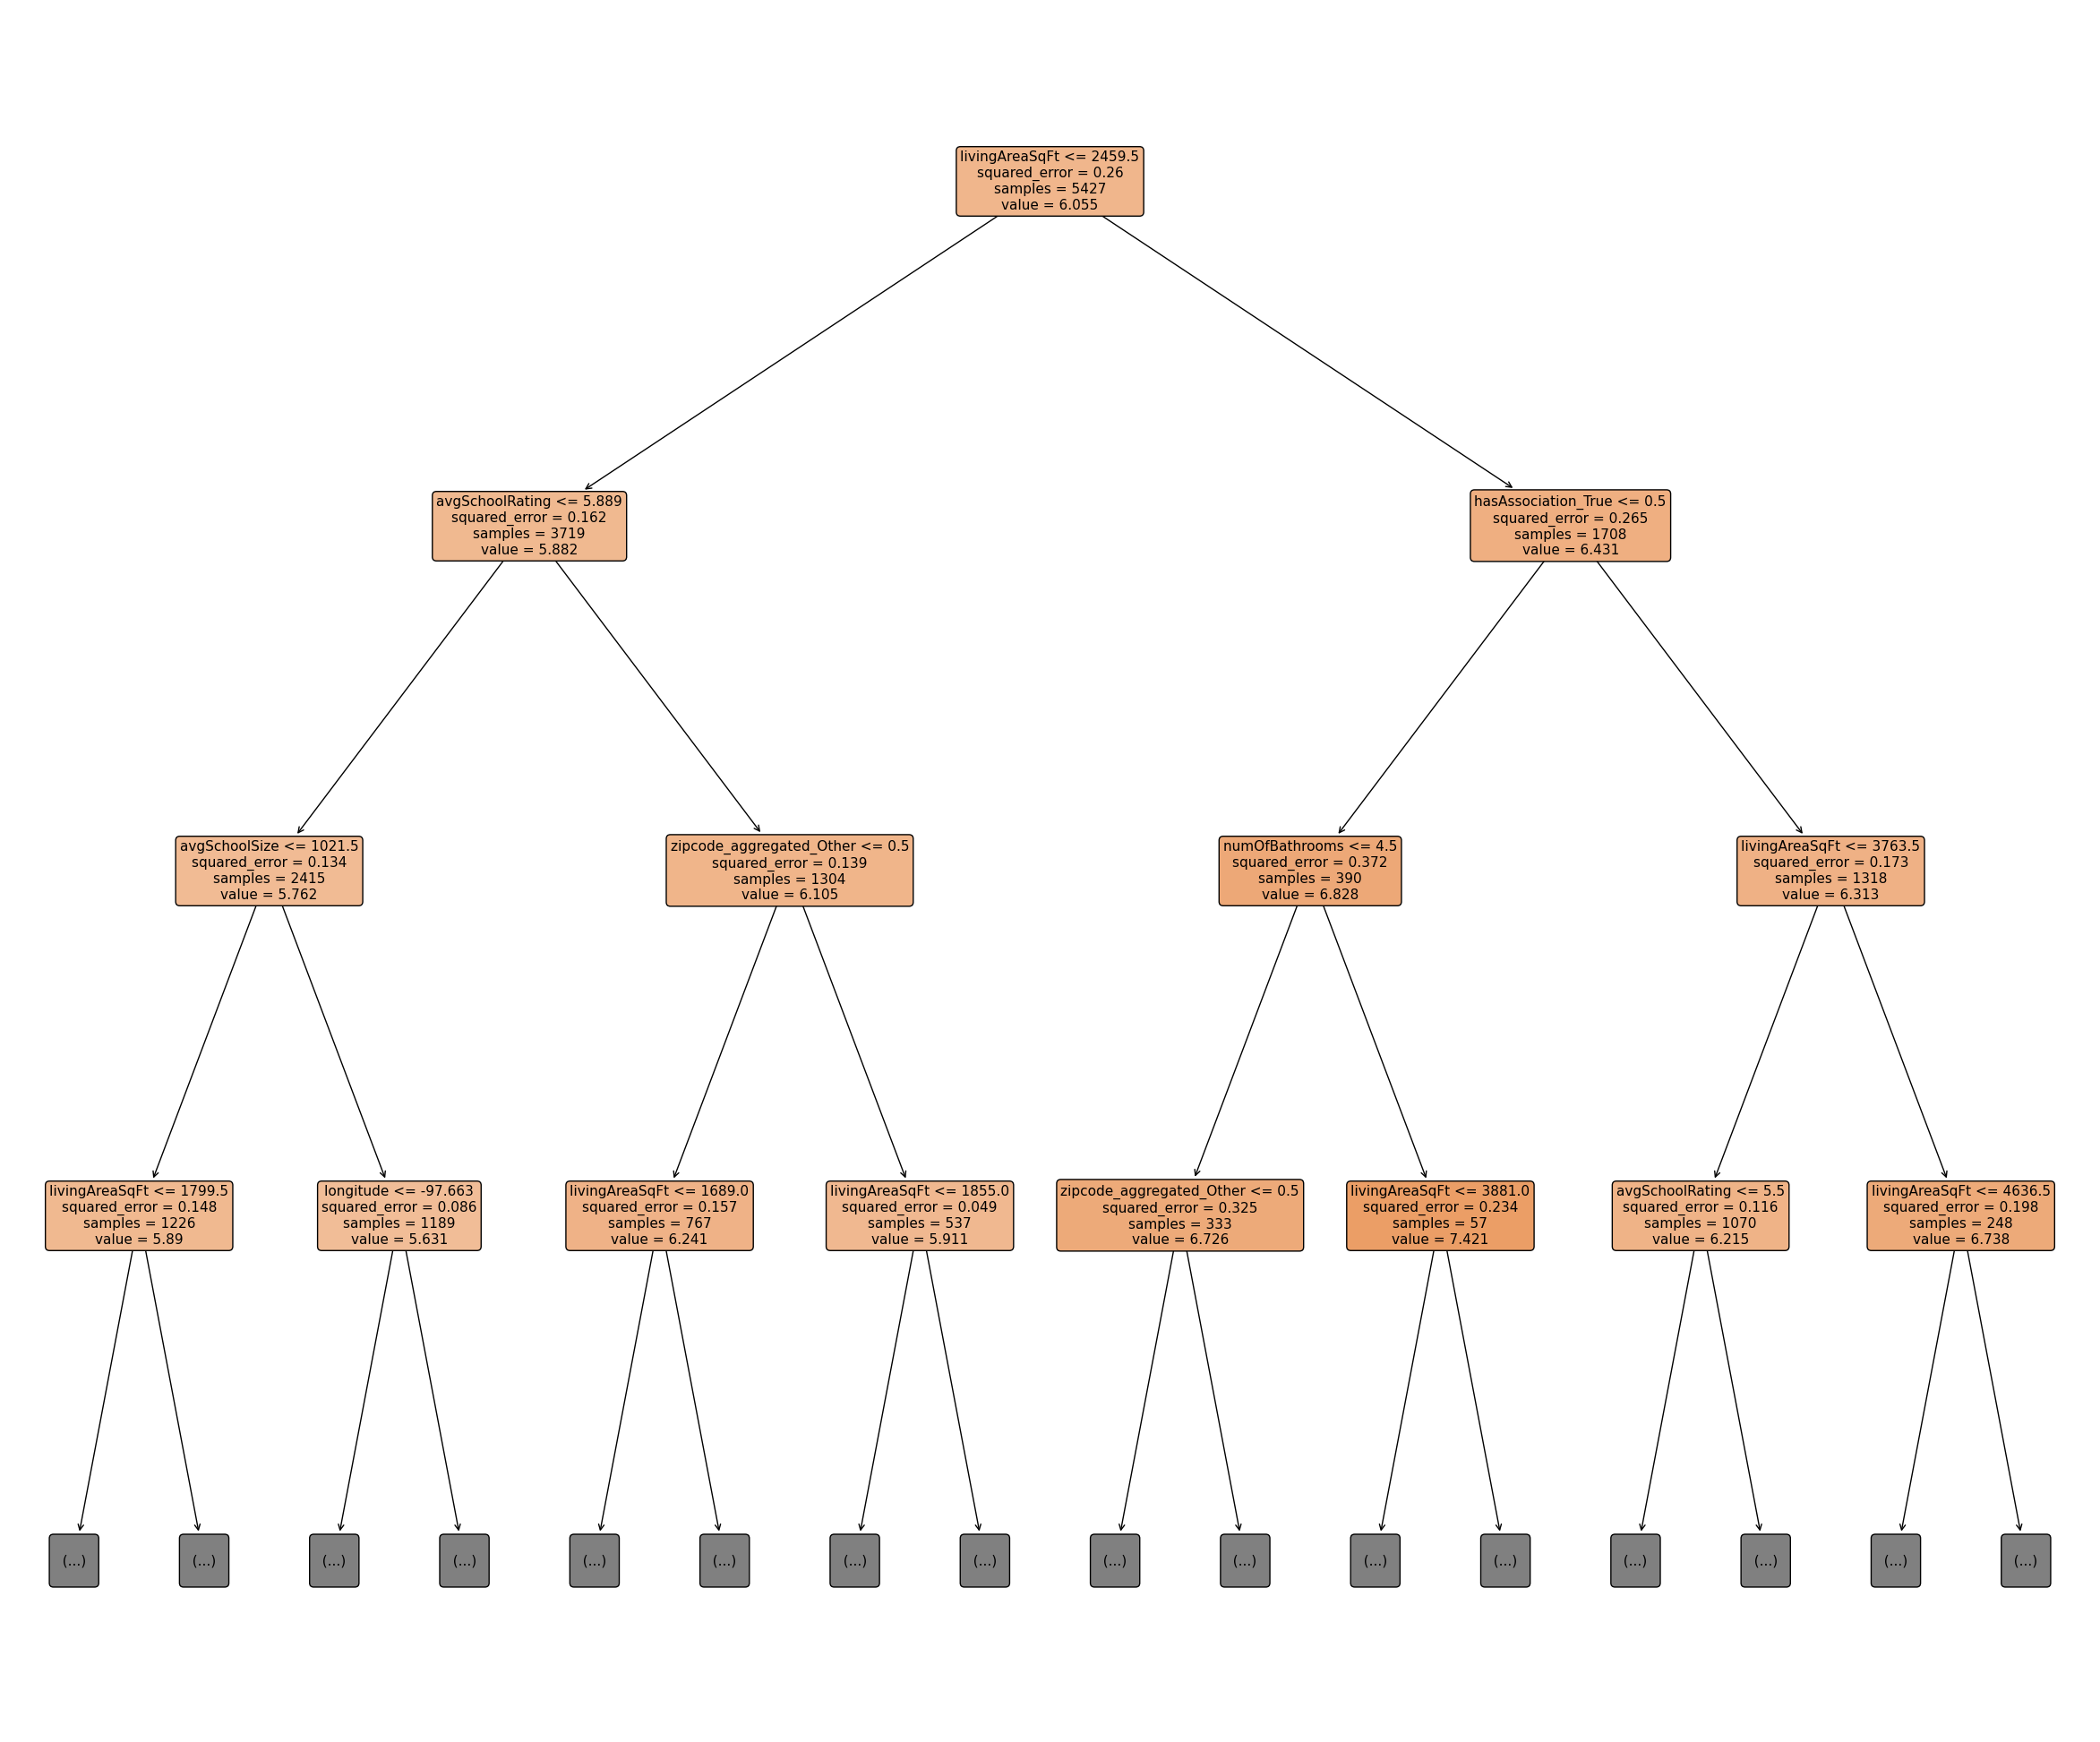

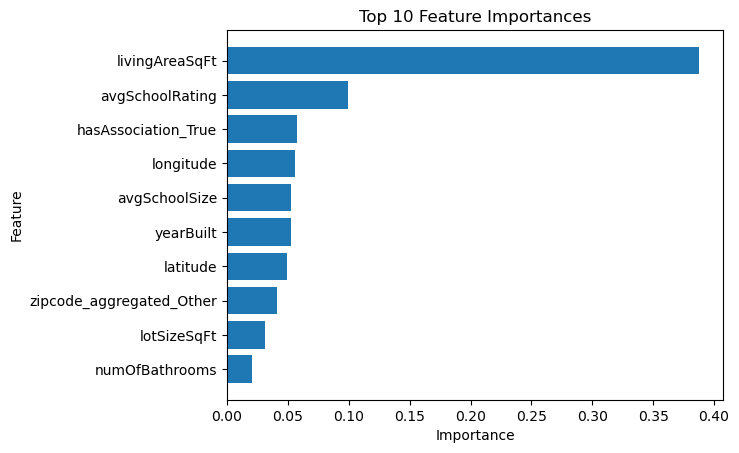

Test Mean Squared Error (MSE): 55210.541644795114


In [333]:
regressor_tree = DecisionTreeRegressor(random_state = 22).fit(X_train, y_train)

plt.figure(figsize=(30, 25))
plot_tree(regressor_tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3, fontsize=11)
# Pruned tree, as the regressor tree by itself is too massive to plot
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': regressor_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)

plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

y_pred_log = regressor_tree.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)
test_mse = mean_squared_error(y_test_original, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")

In [339]:
min_price = np.exp(y.min())
max_price = np.exp(y.max())
price_range = max_price - min_price

print(f"Min Price: {min_price}")
print(f"Max Price: {max_price}")
print(f"Price Range: {price_range}")

Min Price: 5.6
Max Price: 8799.000000000002
Price Range: 8793.400000000001


livingAreaSqFt and numOfBathrooms are the most important features, having the highest importance scores. These features are followed by latitude, hasAssociation_True, numOfAppliances. Additionally, based on the price range, the the squared prediction errors for latestPrice are quite large and this model could stand to improve significantly.

**c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?**

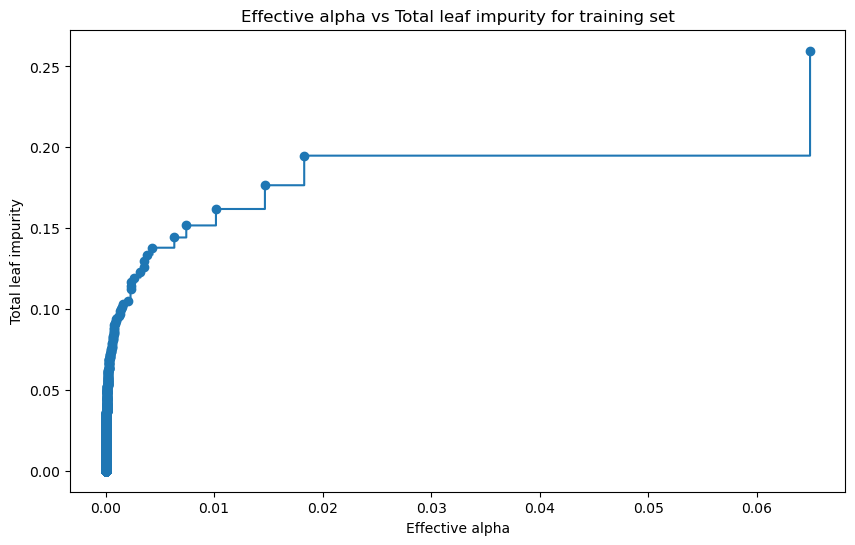

Effective alphas:
[0.00000000e+00 2.61854703e-18 2.61854703e-18 ... 1.46814253e-02
 1.82998254e-02 6.48849497e-02]


In [347]:
path = regressor_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total leaf impurity")
plt.title("Effective alpha vs Total leaf impurity for training set")
plt.show()

print("Effective alphas:")
print(ccp_alphas)

Based on the updated plot, there are notable increases in total leaf impurity at specific alpha values, particularly as the alpha approaches and exceeds 0.02. Pruning the tree at these alpha values significantly simplifies the tree, resulting in a noticeable increase in impurity. At lower alpha values, the increase in impurity is more gradual, allowing for incremental pruning of the tree with small alpha adjustments.

Given this pattern, searching in the range of 0 to 0.1 with finer granularity in the lower range and coarser granularity in the higher range seems ideal.

In [349]:
param_grid = {
    'ccp_alpha': np.concatenate([
        np.linspace(0, 0.01, 20),  # Finer granularity for very low values
        np.linspace(0.01, 0.1, 10)  # Coarser granularity for slightly higher values
    ])
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=22), param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_ccp_alpha = grid_search.best_params_['ccp_alpha']
print(f"Best ccp_alpha: {best_ccp_alpha}")

Best ccp_alpha: 0.0005263157894736842


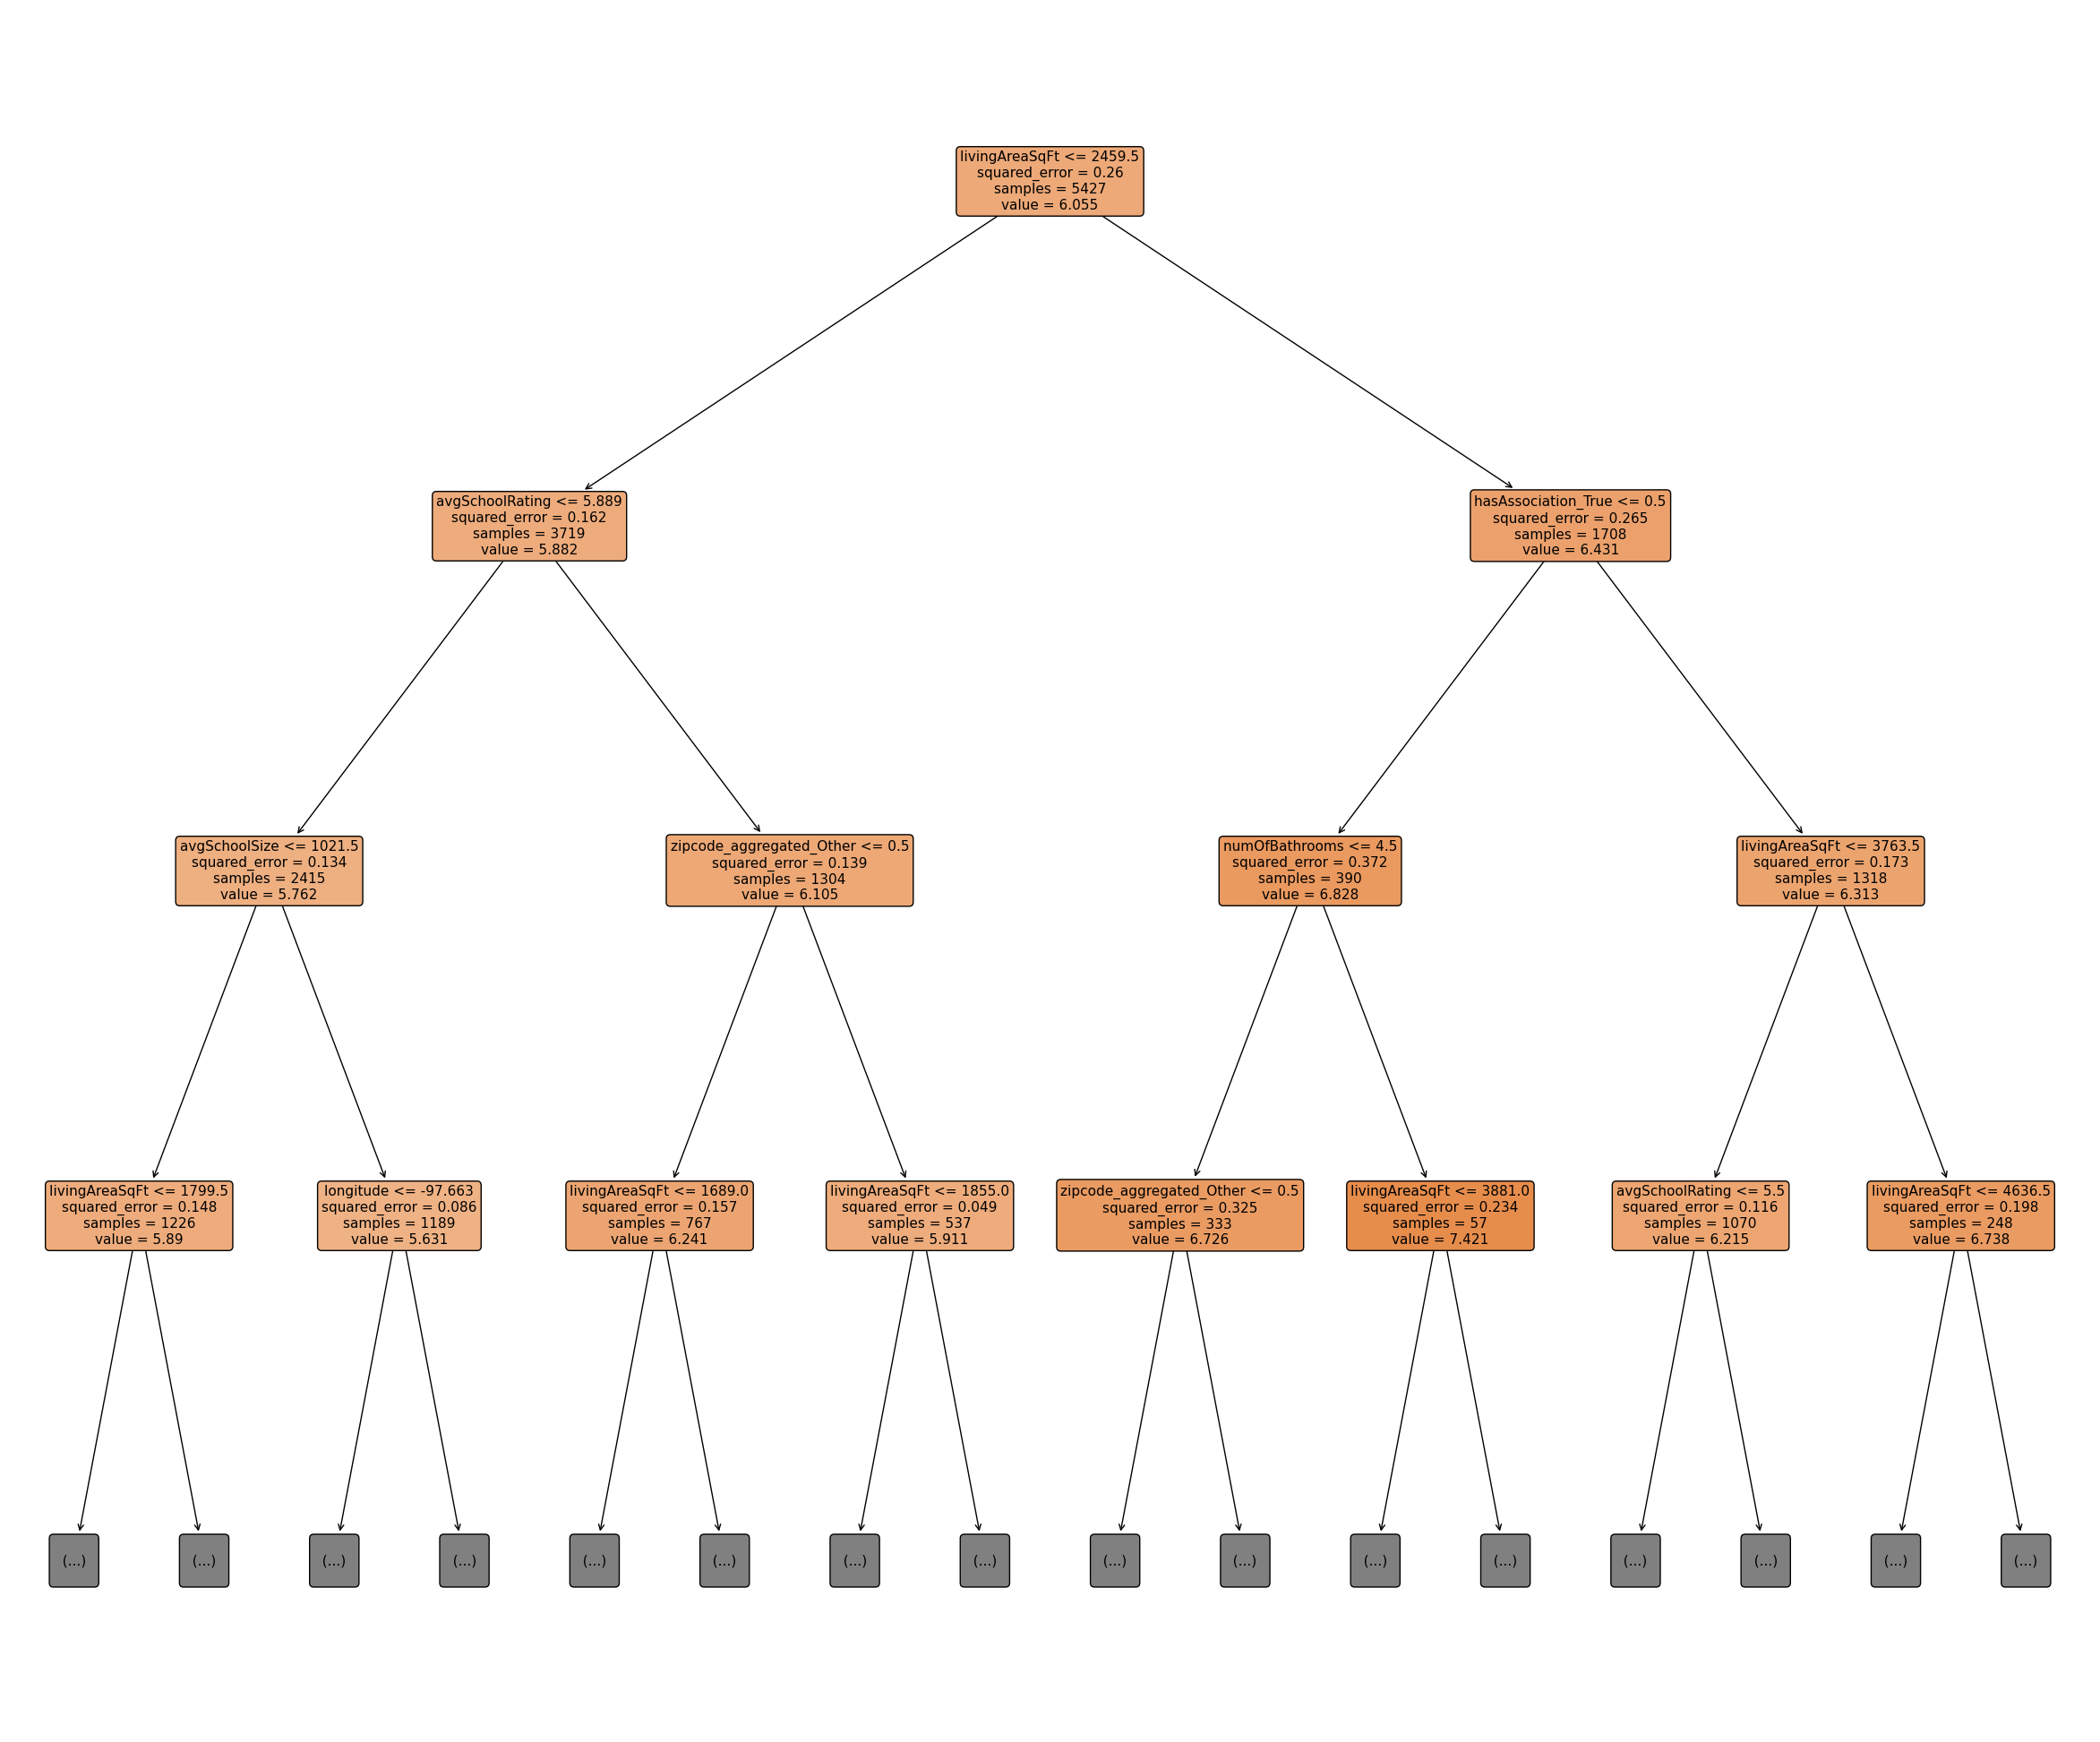

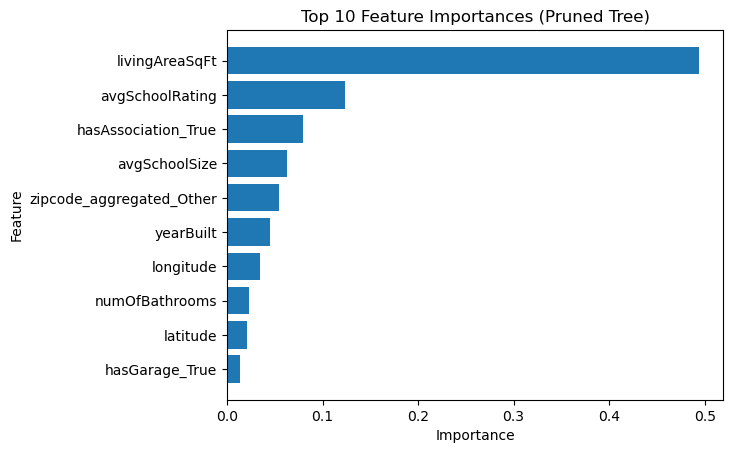

Test Mean Squared Error (MSE) of pruned tree on original scale: 44259.38364302842


In [350]:
pruned_tree = DecisionTreeRegressor(random_state=22, ccp_alpha=best_ccp_alpha)
pruned_tree.fit(X_train, y_train)

plt.figure(figsize=(30, 25))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True, max_depth=3, fontsize=11)
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pruned_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Pruned Tree)')
plt.gca().invert_yaxis()
plt.show()

y_pred_pruned_log = pruned_tree.predict(X_test)
y_pred_pruned = np.exp(y_pred_pruned_log)
y_actual = np.exp(y_test)
test_mse_pruned = mean_squared_error(y_actual, y_pred_pruned)
print(f"Test Mean Squared Error (MSE) of pruned tree on original scale: {test_mse_pruned}")

Pruning the tree did improve the Test MSE by about 10,951 but the Test MSE is still very large.

**d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.**

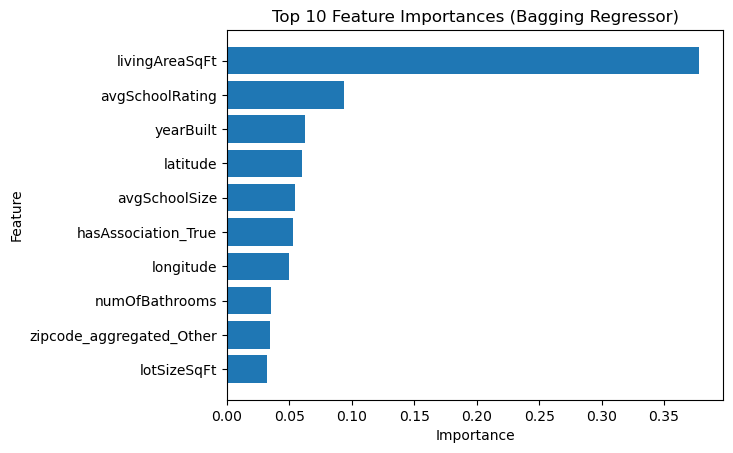

Test Mean Squared Error (MSE): 31105.724953792695


In [354]:
bagging_regressor = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=22),random_state = 22).fit(X_train, y_train)

feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_regressor.estimators_
], axis=0)

feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importances_df.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Bagging Regressor)')
plt.gca().invert_yaxis()
plt.show()

y_pred_log = bagging_regressor.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)
test_mse = mean_squared_error(y_test_original, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")

The bagging test MSE is significantly better than even the pruned tree based on cross-validation, a 13,154 decrease!

**e)  Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.**

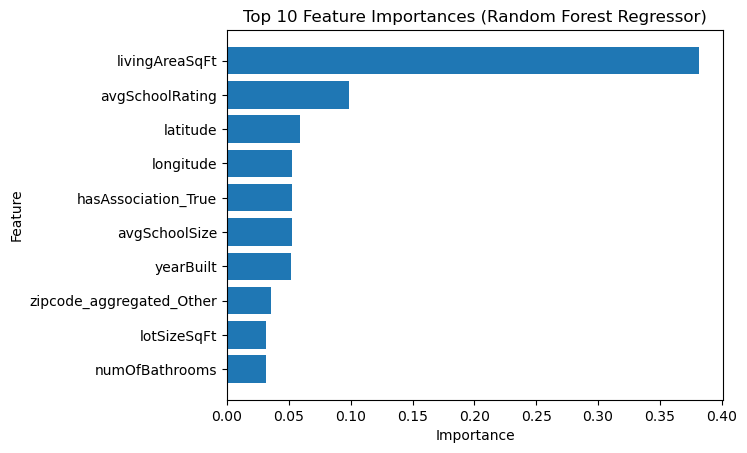

Test Mean Squared Error (MSE): 27804.80530550969


In [358]:
random_forest_regressor = RandomForestRegressor(random_state=22).fit(X_train, y_train)

feature_importances = random_forest_regressor.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importances_df.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Random Forest Regressor)')
plt.gca().invert_yaxis()
plt.show()

y_pred_log = random_forest_regressor.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)
test_mse = mean_squared_error(y_test_original, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")

The random forest performs better in terms of test MSE than the bagging model by about 3301.

To show the effect of m, the number of variables considered at each split in the random forest, on the error rate obtained, I decided to plot the test MSE for every possible value of m.

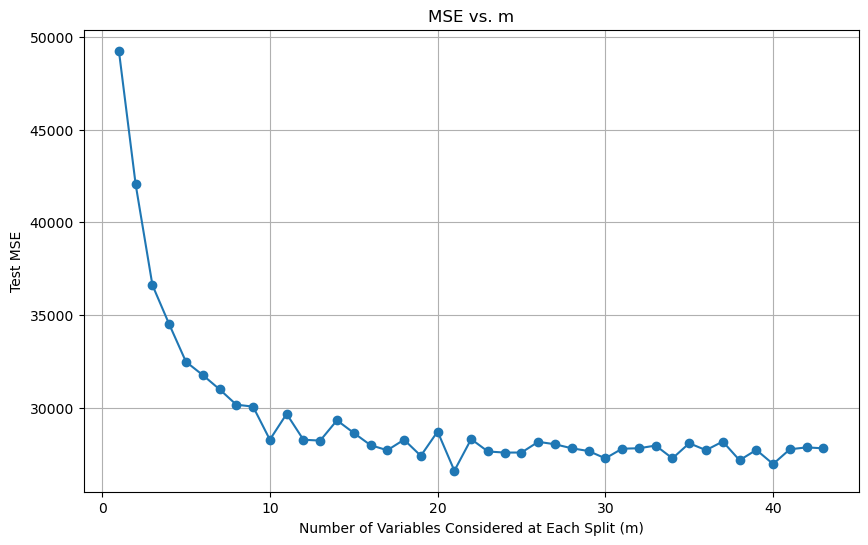

In [363]:
m_values = range(1, X_train.shape[1] + 1)
mse_values = []

for m in m_values:
    rf_model = RandomForestRegressor(max_features=m, random_state=22)
    rf_model.fit(X_train, y_train)
    y_pred_log = rf_model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_original = np.exp(y_test)
    mse = mean_squared_error(y_test_original, y_pred)
    mse_values.append(mse)

mtry_mse_df = pd.DataFrame({'m': m_values, 'MSE': mse_values})

plt.figure(figsize=(10, 6))
plt.plot(mtry_mse_df['m'], mtry_mse_df['MSE'], marker='o', linestyle='-')
plt.xlabel('Number of Variables Considered at Each Split (m)')
plt.ylabel('Test MSE')
plt.title('MSE vs. m')
plt.grid(True)
plt.show()

Based on this graph, at this stage, considering 21 random variables at each split for the random forest results in the best test MSE.

**f) Now analyze the data using BART, and report your results.**

*Please see attached R-Script for BART code.*

I obtained a test MSE of 30,622 for BART, which is worse than the random forest but better than the bagging model.

## 3: Creating a set of predictions to enter the contest based on the holdout data using any method.

I analyzed the predictors that appeared to have high colinearity with each other. However, any modifications I considered as a form of feature engineering ended up worsening the test MSE.

In [368]:
corr_matrix = X.corr()
threshold = 0.8
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.mask(mask)
high_corr = corr_matrix_masked[(corr_matrix_masked >= threshold) | (corr_matrix_masked <= -threshold)].stack().reset_index()
print(high_corr)

          level_0         level_1         0
0  numOfBathrooms  livingAreaSqFt  0.813418
1  hasGarage_True    garageSpaces  0.838202


In [45]:
#X['garageSpaceRatio'] = X['garageSpaces'] / X['hasGarage_True']
#X['garageSpaceRatio'].replace([np.inf, np.nan], 0)

In [46]:
#X['bathroomsPerSqFt'] = X['numOfBathrooms'] / X['livingAreaSqFt']
#X['bathroomsPerSqFt'].replace([np.inf, np.nan], 0)

In [47]:
#X = X.drop(columns=['garageSpaces', 'numOfBathrooms', 'livingAreaSqFt'])
#X = X.drop(columns=['garageSpaces'])
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.2)

The code below scales the training data to try and improve the forthcoming results for KNN.

In [370]:
#X = df.drop(columns = 'latestPrice')
#y = df['latestPrice']

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(model, X_test, y_test):
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_original = np.exp(y_test)
    mse = mean_squared_error(y_test_original, y_pred)
    print(f'Test MSE: {mse:.4f}')

#def evaluate_model(model, X_test, y_test):
    #y_pred = model.predict(X_test)
    #mse = mean_squared_error(y_test, y_pred)
    #print(f'Test MSE: {mse:.4f}')

The following code uses 10-Fold GridSearch CV to find the optimal model parameters and then report that best model's results on the Test MSE.

In [391]:
# Bagging Regressor
bagging_params = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 10, 20],
}
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=22), random_state=22, n_jobs=-1)
bagging_grid = GridSearchCV(bagging, bagging_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
bagging_grid.fit(X_train, y_train)
evaluate_model(bagging_grid, X_test, y_test)
print("Best Parameters:", bagging_grid.best_params_)

Test MSE: 28104.2103
Best Parameters: {'estimator__max_depth': None, 'n_estimators': 50}


In [382]:
# Random Forest Regressor
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestRegressor(random_state=22, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
evaluate_model(rf_grid, X_test, y_test)
print("Best Parameters:", rf_grid.best_params_)

Test MSE: 31609.5928
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}


In [383]:
# KNN Regressor
knn_params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]
}
knn = KNeighborsRegressor(n_jobs=-1)
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)
evaluate_model(knn_grid, X_test_scaled, y_test)
print("Best Parameters:", knn_grid.best_params_)

Test MSE: 59369.3936
Best Parameters: {'n_neighbors': 7}


In [384]:
# AdaBoost Regressor
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}
ada = AdaBoostRegressor(random_state=22)
ada_grid = GridSearchCV(ada, ada_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
ada_grid.fit(X_train, y_train)
evaluate_model(ada_grid, X_test, y_test)
print("Best Parameters:", ada_grid.best_params_)

Test MSE: 58964.2789
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}


In [385]:
# Gradient Boosting Regressor
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_samples_leaf': [1, 2, 4],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2']
}
gb = GradientBoostingRegressor(random_state=22)
gb_grid = GridSearchCV(gb, gb_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
evaluate_model(gb_grid, X_test, y_test)
print("Best Parameters:", gb_grid.best_params_)

Test MSE: 26609.8020
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200, 'subsample': 1.0}


In [386]:
# XGBoost Regressor
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBRegressor(random_state=22, n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
evaluate_model(xgb_grid, X_test, y_test)
print("Best Parameters:", xgb_grid.best_params_)

Test MSE: 29358.2884
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


In [387]:
# LightGBM Regressor
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.8, 1.0]
}
lgb = LGBMRegressor(random_state=22, n_jobs=-1,verbosity=-1)
lgb_grid = GridSearchCV(lgb, lgb_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train, y_train)
evaluate_model(lgb_grid, X_test, y_test)
print("Best Parameters:", lgb_grid.best_params_)

Test MSE: 28392.3248
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


In [388]:
# Lasso Regression
lasso_params = {
    'alpha': [0.01, 0.1, 1, 10]
}
lasso = Lasso(random_state=22)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)
evaluate_model(lasso_grid, X_test, y_test)
print("Best Parameters:", lasso_grid.best_params_)

Test MSE: 55672.9310
Best Parameters: {'alpha': 0.01}


In [389]:
# Ridge Regression
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10]
}
ridge = Ridge(random_state=22)
ridge_grid = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
evaluate_model(ridge_grid, X_test, y_test)
print("Best Parameters:", ridge_grid.best_params_)

Test MSE: 40422.2810
Best Parameters: {'alpha': 1}


In [390]:
# PLS (Partial Least Squares)
pls_params = {
    'n_components': [2, 5, 10, 15]
}
pls = PLSRegression()
pls_grid = GridSearchCV(pls, pls_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
pls_grid.fit(X_train, y_train)
evaluate_model(pls_grid, X_test, y_test)
print("Best Parameters:", pls_grid.best_params_)

Test MSE: 40211.9507
Best Parameters: {'n_components': 15}


To improve these results, I tried using SFS Feature Selection on my best performing models.

**Note: This has significant runtime! I have saved the results of my work and have commented out SFS code.**

In [433]:
# Bagging Wrapper Method - SFS

best_bagging = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=None, random_state=22),
                                n_estimators=50, random_state=22, n_jobs=-1)

#sfs = SFS(best_bagging, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', 
          #cv=10, n_jobs=-1).fit(X_train,y_train)

#X_train_selected = sfs.transform(X_train)
#X_test_selected = sfs.transform(X_test)

#predefined_selected_features = ['latitude', 'longitude', 'yearBuilt', 'numOfPhotos', 'numOfWaterfrontFeatures', 'numOfWindowFeatures',
#                                 'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'MedianStudentsPerTeacher', 'numOfBathrooms', 
#                                 'numOfBedrooms', 'numOfStories', 'hasSpa_True', 'hasView_True', 'latest_salemonth_2', 'latest_salemonth_3', 
#                                 'latest_salemonth_4', 'latest_salemonth_6', 'latest_salemonth_8', 'latest_salemonth_12', 
#                                 'zipcode_aggregated_East Austin']

predefined_selected_features = ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 'numOfParkingFeatures', 
                                'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 
                                'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'hasSpa_True', 'latest_salemonth_2', 'latest_salemonth_4', 
                                'latest_salemonth_5', 'latest_salemonth_8', 'latest_salemonth_11', 'zipcode_aggregated_East Austin', 
                                'zipcode_aggregated_Other']

X_train_selected = X_train[predefined_selected_features]
X_test_selected = X_test[predefined_selected_features]

#selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

selected_feature_names = predefined_selected_features

print("Selected feature names:", selected_feature_names)

Selected feature names: ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'hasSpa_True', 'latest_salemonth_2', 'latest_salemonth_4', 'latest_salemonth_5', 'latest_salemonth_8', 'latest_salemonth_11', 'zipcode_aggregated_East Austin', 'zipcode_aggregated_Other']


In [434]:
best_bagging.fit(X_train_selected, y_train)
evaluate_model(best_bagging, X_test_selected, y_test)
# Worse Performance - 28679.8428 before log transform

Test MSE: 28617.2819


In [435]:
# Random Forest Wrapper Method - SFS

#best_rf = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, n_estimators=200,
                              #random_state=22, n_jobs=-1)

best_rf = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, n_estimators=200,
                               random_state=22, n_jobs=-1)

#sfs = SFS(best_rf, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', 
          #cv=10, n_jobs=-1).fit(X_train,y_train)

#X_train_selected = sfs.transform(X_train)
#X_test_selected = sfs.transform(X_test)

#predefined_selected_features = ['latitude', 'longitude', 'yearBuilt', 'latest_saleyear', 'numOfPatioAndPorchFeatures',
#                                'numOfWaterfrontFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
#                                'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'hasSpa_True', 
#                                'latest_salemonth_2', 'latest_salemonth_5', 'latest_salemonth_6', 
#                                'latest_salemonth_11', 'latest_salemonth_12', 'zipcode_aggregated_East Austin', 
#                                'zipcode_aggregated_North Austin', 'zipcode_aggregated_Other', 
#                                'zipcode_aggregated_West Austin']

predefined_selected_features = ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 'numOfParkingFeatures', 
                                'numOfPatioAndPorchFeatures', 'numOfWindowFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
                                'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'hasAssociation_True', 
                                'latest_salemonth_2', 'latest_salemonth_5', 'zipcode_aggregated_East Austin', 'zipcode_aggregated_North Austin', 
                                'zipcode_aggregated_Other', 'zipcode_aggregated_South Austin']

X_train_selected = X_train[predefined_selected_features]
X_test_selected = X_test[predefined_selected_features]

#selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

selected_feature_names = predefined_selected_features

print("Selected feature names:", selected_feature_names)

Selected feature names: ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfWindowFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'hasAssociation_True', 'latest_salemonth_2', 'latest_salemonth_5', 'zipcode_aggregated_East Austin', 'zipcode_aggregated_North Austin', 'zipcode_aggregated_Other', 'zipcode_aggregated_South Austin']


In [436]:
best_rf.fit(X_train_selected, y_train)
evaluate_model(best_rf, X_test_selected, y_test)
# Improvement - 25950.4844 before log transform 

Test MSE: 28732.2703


In [488]:
# Gradient Boosting Wrapper Method - SFS

#best_gb = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, max_features='sqrt', min_samples_leaf=1, 
                                    #n_estimators=200, subsample=1, random_state=22)

best_gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, max_features='sqrt', min_samples_leaf=2, 
                                    n_estimators=200, subsample=1, random_state=22)

#sfs = SFS(best_gb, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', 
          #cv=10, n_jobs=-1).fit(X_train,y_train)

#X_train_selected = sfs.transform(X_train)
#X_test_selected = sfs.transform(X_test)

#predefined_selected_features = ['latitude', 'longitude', 'yearBuilt', 'numOfPhotos', 'numOfAccessibilityFeatures', 
#                                'numOfAppliances', 'numOfWindowFeatures', 'livingAreaSqFt', 'numOfBathrooms', 
#                                'numOfBedrooms', 'hasAssociation_True', 'hasView_True', 'latest_salemonth_2', 
#                                'latest_salemonth_5', 'latest_salemonth_6', 'latest_salemonth_7', 
#                                'latest_salemonth_8', 'latest_salemonth_9', 'latest_salemonth_10', 
#                                'zipcode_aggregated_East Austin', 'zipcode_aggregated_Other', 
#                                'zipcode_aggregated_South Austin']

predefined_selected_features = ['latitude', 'longitude', 'yearBuilt', 'latest_saleyear', 'numOfPhotos', 'numOfAppliances', 'numOfSecurityFeatures', 
                                'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolRating', 'avgSchoolSize', 
                                'MedianStudentsPerTeacher', 'hasAssociation_True', 'hasGarage_True', 'latest_salemonth_2', 'latest_salemonth_3', 
                                'latest_salemonth_4', 'latest_salemonth_6', 'latest_salemonth_7', 'latest_salemonth_10', 
                                'zipcode_aggregated_West Austin']

X_train_selected = X_train[predefined_selected_features]
X_test_selected = X_test[predefined_selected_features]

#selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

selected_feature_names = predefined_selected_features

print("Selected feature names:", selected_feature_names)

Selected feature names: ['latitude', 'longitude', 'yearBuilt', 'latest_saleyear', 'numOfPhotos', 'numOfAppliances', 'numOfSecurityFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'hasAssociation_True', 'hasGarage_True', 'latest_salemonth_2', 'latest_salemonth_3', 'latest_salemonth_4', 'latest_salemonth_6', 'latest_salemonth_7', 'latest_salemonth_10', 'zipcode_aggregated_West Austin']


In [490]:
best_gb.fit(X_train_selected, y_train)
evaluate_model(best_gb, X_test_selected, y_test)
# Improvement - 30664.8350 before log transform

Test MSE: 25401.5143


In [439]:
# Extreme Gradient Boosting (XGB) Wrapper Method - SFS

#best_xgb = XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, 
                        #n_estimators=200, subsample=0.8, random_state =22, n_jobs =-1)

best_xgb = XGBRegressor(colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, 
                        n_estimators=200, subsample=1.0, random_state =22, n_jobs =-1)

#sfs = SFS(best_xgb, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', 
          #cv=10, n_jobs=-1).fit(X_train,y_train)

#X_train_selected = sfs.transform(X_train)
#X_test_selected = sfs.transform(X_test)

#predefined_selected_features = ['latitude', 'longitude', 'yearBuilt', 'latest_saleyear', 
#                                'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 
#                                'avgSchoolDistance', 'MedianStudentsPerTeacher', 'numOfBathrooms', 
#                                'numOfBedrooms', 'hasView_True', 'latest_salemonth_2', 'latest_salemonth_3', 
#                                'latest_salemonth_4', 'latest_salemonth_5', 'latest_salemonth_6', 
#                                'latest_salemonth_8', 'latest_salemonth_10', 'zipcode_aggregated_East Austin', 
#                                'zipcode_aggregated_North Austin', 'zipcode_aggregated_South Austin']

predefined_selected_features = ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 
                                'numOfPhotos', 'numOfAppliances', 'numOfParkingFeatures', 
                                'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
                                'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 
                                'numOfBedrooms', 'hasAssociation_True', 'latest_salemonth_4', 'latest_salemonth_9', 
                                'latest_salemonth_12', 'zipcode_aggregated_Other']

X_train_selected = X_train[predefined_selected_features]
X_test_selected = X_test[predefined_selected_features]

#selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

selected_feature_names = predefined_selected_features

print("Selected feature names:", selected_feature_names)

Selected feature names: ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 'numOfPhotos', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms', 'hasAssociation_True', 'latest_salemonth_4', 'latest_salemonth_9', 'latest_salemonth_12', 'zipcode_aggregated_Other']


In [440]:
best_xgb.fit(X_train_selected, y_train)
evaluate_model(best_xgb, X_test_selected, y_test)
# Improvement - 31058.2608 before log transform

Test MSE: 29230.4760


In [441]:
# Light Gradient Boosting Machine (LGBM) Wrapper Method - SFS

#best_lgb = LGBMRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=1, 
                         #n_estimators=50, subsample=0.8, random_state=22, n_jobs=-1, verbosity=-1)

best_lgb = LGBMRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_weight=1, 
                         n_estimators=200, subsample=0.8, random_state=22, n_jobs=-1, verbosity=-1)

#sfs = SFS(best_lgb, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', 
          #cv=10, n_jobs=-1).fit(X_train,y_train)

#X_train_selected = sfs.transform(X_train)
#X_test_selected = sfs.transform(X_test)

#predefined_selected_features = ['latitude', 'longitude', 'yearBuilt', 'latest_saleyear', 'numOfAppliances', 
#                                'numOfParkingFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'numOfBathrooms', 
#                                'hasGarage_True', 'hasView_True', 'latest_salemonth_2', 'latest_salemonth_3', 
#                                'latest_salemonth_4', 'latest_salemonth_5', 'latest_salemonth_7', 
#                                'latest_salemonth_8', 'latest_salemonth_9', 'latest_salemonth_10', 
#                                'latest_salemonth_12', 'zipcode_aggregated_East Austin', 
#                                'zipcode_aggregated_North Austin']

predefined_selected_features = ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 
                                'numOfAppliances', 'numOfParkingFeatures', 'numOfWindowFeatures', 'lotSizeSqFt', 
                                'livingAreaSqFt', 'avgSchoolSize', 'numOfBathrooms', 'numOfBedrooms', 
                                'hasAssociation_True', 'hasGarage_True', 'hasSpa_True', 'latest_salemonth_2', 
                                'latest_salemonth_8', 'latest_salemonth_11', 'latest_salemonth_12', 
                                'zipcode_aggregated_Other', 'zipcode_aggregated_West Austin']

X_train_selected = X_train[predefined_selected_features]
X_test_selected = X_test[predefined_selected_features]

#selected_feature_names = [name for name, selected in zip(X_train.columns, sfs.get_support()) if selected]

selected_feature_names = predefined_selected_features

print("Selected feature names:", selected_feature_names)

Selected feature names: ['latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'latest_saleyear', 'numOfAppliances', 'numOfParkingFeatures', 'numOfWindowFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolSize', 'numOfBathrooms', 'numOfBedrooms', 'hasAssociation_True', 'hasGarage_True', 'hasSpa_True', 'latest_salemonth_2', 'latest_salemonth_8', 'latest_salemonth_11', 'latest_salemonth_12', 'zipcode_aggregated_Other', 'zipcode_aggregated_West Austin']


In [442]:
best_lgb.fit(X_train_selected, y_train)
evaluate_model(best_lgb, X_test_selected, y_test)
# Improvement - 26889.8379 before log transform

Test MSE: 27440.5970


I am now going to predict prices on the holdout set and output the transformed holdout CSV with the predicted 'latestPrice' values based on my best performing model, the Random Forest.

In [492]:
df_holdout['zipcode_aggregated'] = df_holdout['zipcode'].apply(aggregate_zipcode)
df_holdout = df_holdout.drop(columns=['zipcode','homeType','latest_saledate'])

df_holdout['hasAssociation'] = df_holdout['hasAssociation'].astype('category')
df_holdout['hasGarage'] = df_holdout['hasGarage'].astype('category')
df_holdout['hasSpa'] = df_holdout['hasSpa'].astype('category')
df_holdout['hasView'] = df_holdout['hasView'].astype('category')
df_holdout['latest_salemonth'] = df_holdout['latest_salemonth'].astype('category')
df_holdout['zipcode_aggregated'] = df_holdout['zipcode_aggregated'].astype('category')

df_holdout = pd.get_dummies(df_holdout, drop_first=True)

df_holdout = df_holdout.reindex(columns=df.columns.drop('latestPrice'), fill_value=0)

selected_feature_names = ['latitude', 'longitude', 'yearBuilt', 'latest_saleyear', 'numOfPhotos', 'numOfAppliances', 'numOfSecurityFeatures', 
                                'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolRating', 'avgSchoolSize', 
                                'MedianStudentsPerTeacher', 'hasAssociation_True', 'hasGarage_True', 'latest_salemonth_2', 'latest_salemonth_3', 
                                'latest_salemonth_4', 'latest_salemonth_6', 'latest_salemonth_7', 'latest_salemonth_10', 
                                'zipcode_aggregated_West Austin']

X_holdout_selected = df_holdout[selected_feature_names]

y_holdout_pred_log = best_gb.predict(X_holdout_selected)
df_holdout['latestPrice'] = np.exp(y_holdout_pred_log)

In [496]:
df_holdout.to_csv('austinhouses_holdout_with_predictions.csv', index=False)

## Other Code

In [ ]:
#from sklearn.model_selection import KFold
#from sklearn.pipeline import Pipeline

#rf_params = {
#    'rf__n_estimators': [100, 200],
#    'rf__max_depth': [None, 10, 20],
#    'rf__min_samples_leaf': [1, 2, 4],
#    'rf__max_features': ['sqrt', 'log2']
#}

#pipe = Pipeline([
#    ('sfs', SFS(RandomForestRegressor(random_state=22, n_jobs=-1),
#                n_features_to_select='auto',
#                direction='backward',
#                scoring='neg_mean_squared_error',
#                cv=5,
#                n_jobs=-1)),
#    ('rf', RandomForestRegressor(random_state=22, n_jobs=-1))
#])

#outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

#grid_search = GridSearchCV(pipe, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Nested CV MSE:", -np.mean(nested_scores))

#grid_search.fit(X_train, y_train)

#best_model = grid_search.best_estimator_
#best_params = grid_search.best_params_

#selected_features_mask = best_model.named_steps['sfs'].get_support()
#selected_feature_names = X_train.columns[selected_features_mask]

#print("Best Parameters:", best_params)
#print("Selected Features:", list(selected_feature_names))

#X_test_selected = X_test[selected_feature_names]

#evaluate_model(best_model, X_test_selected, y_test)

Summary of large error cases:
         latitude   longitude  garageSpaces    yearBuilt  latest_saleyear  \
count  543.000000  543.000000    543.000000   543.000000       543.000000   
mean    30.297127  -97.780296      1.570902  1984.399632      2019.182320   
std      0.064249    0.061755      1.499705    28.071347         0.831739   
min     30.138678  -98.002831      0.000000  1907.000000      2018.000000   
25%     30.250734  -97.804756      0.000000  1962.000000      2018.000000   
50%     30.295134  -97.768082      2.000000  1989.000000      2019.000000   
75%     30.343050  -97.745209      2.000000  2008.000000      2020.000000   
max     30.505104  -97.608902     12.000000  2020.000000      2021.000000   

       numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
count   543.000000                  543.000000       543.000000   
mean     37.215470                    0.011050         3.616943   
std      25.850614                    0.104632         2.056546   
min     

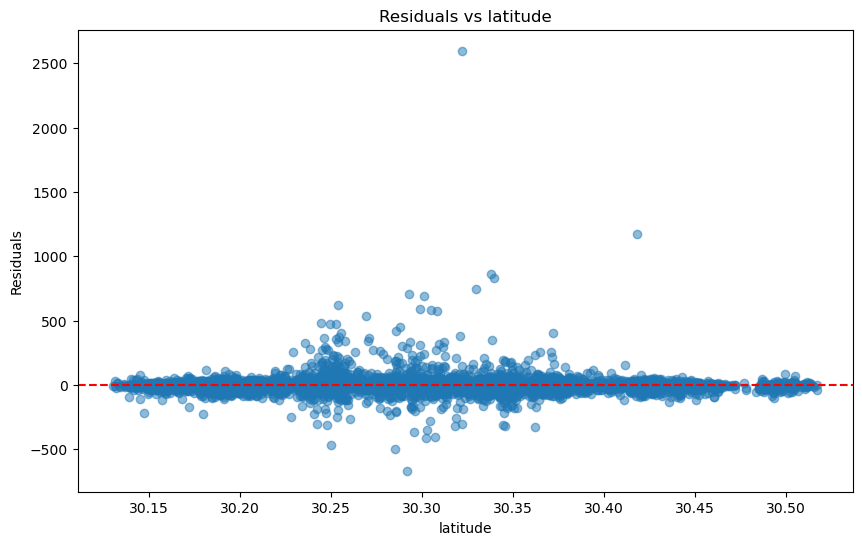

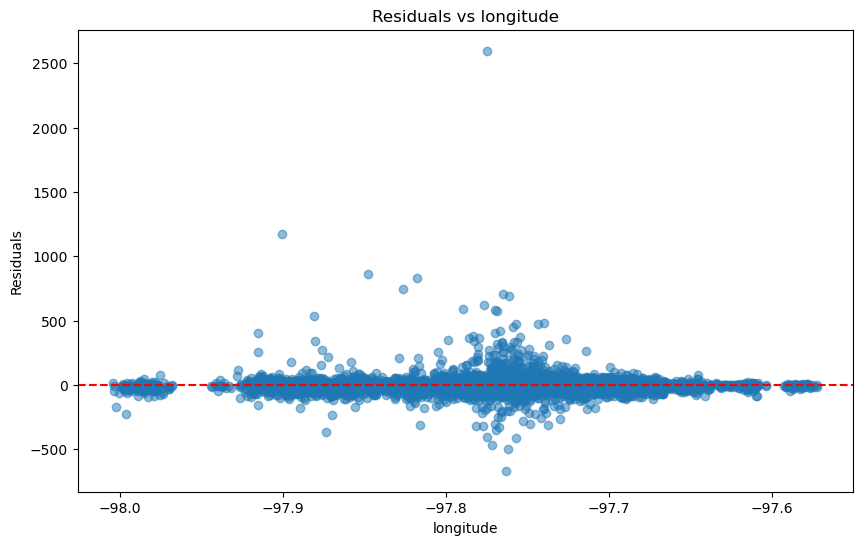

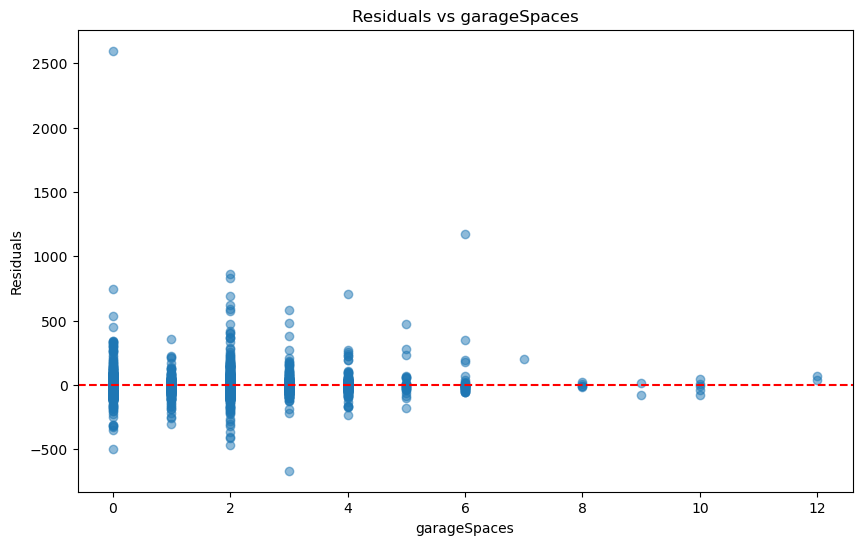

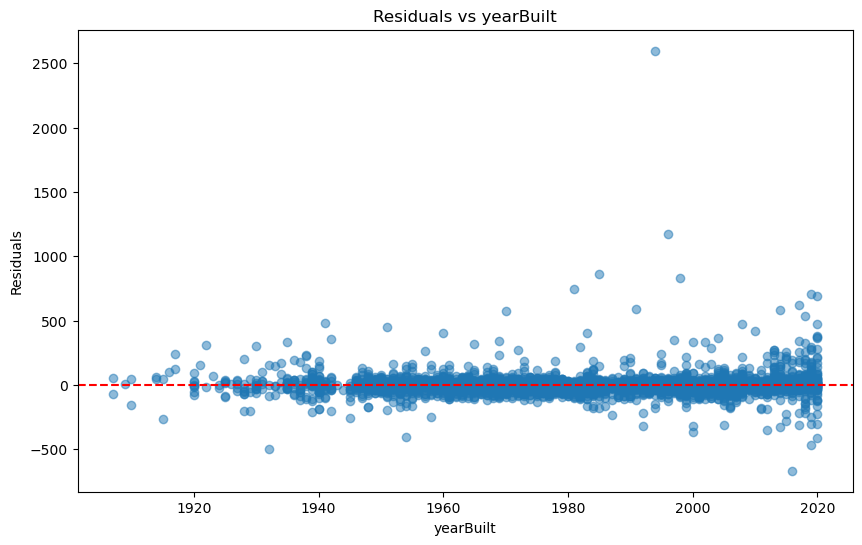

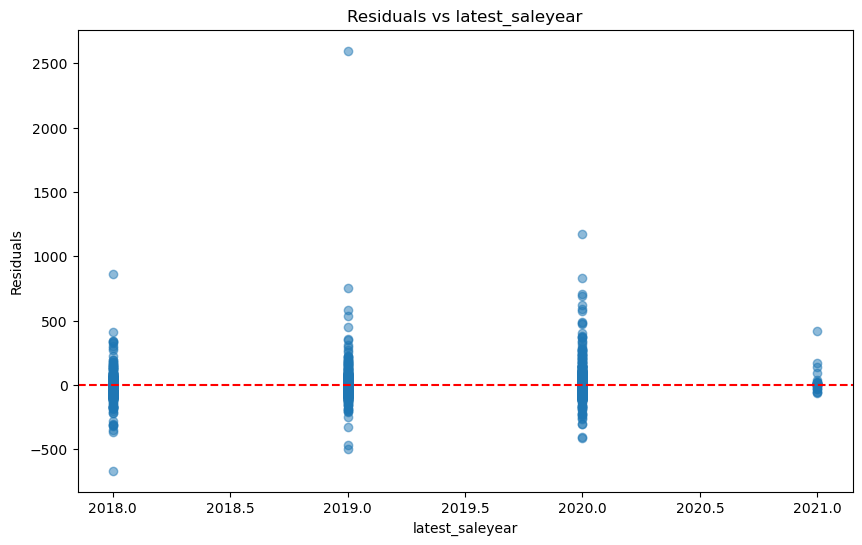

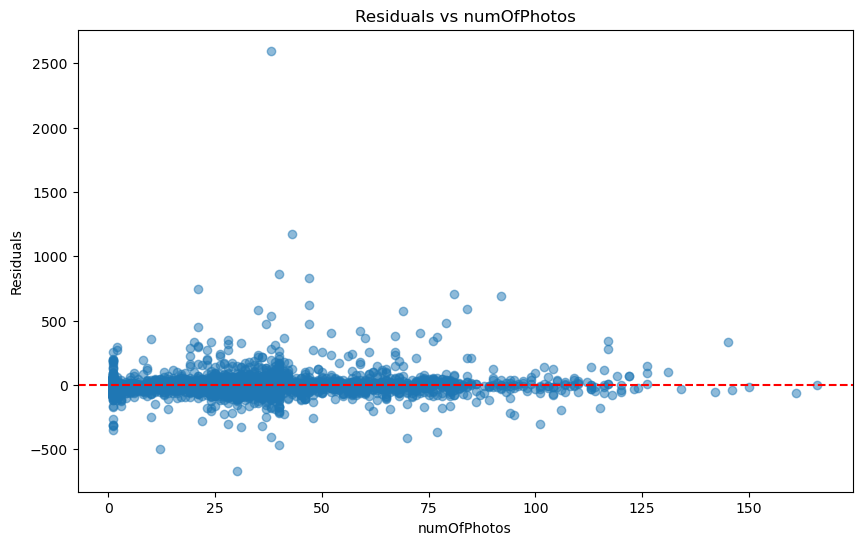

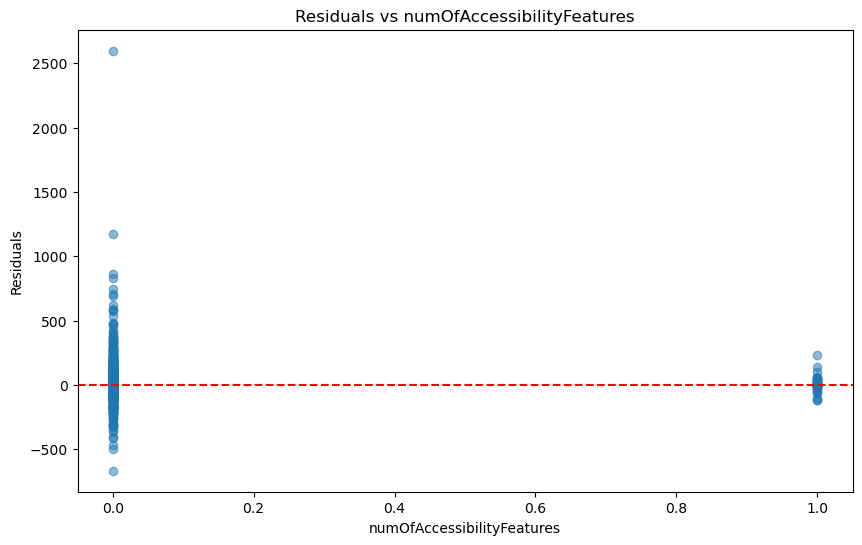

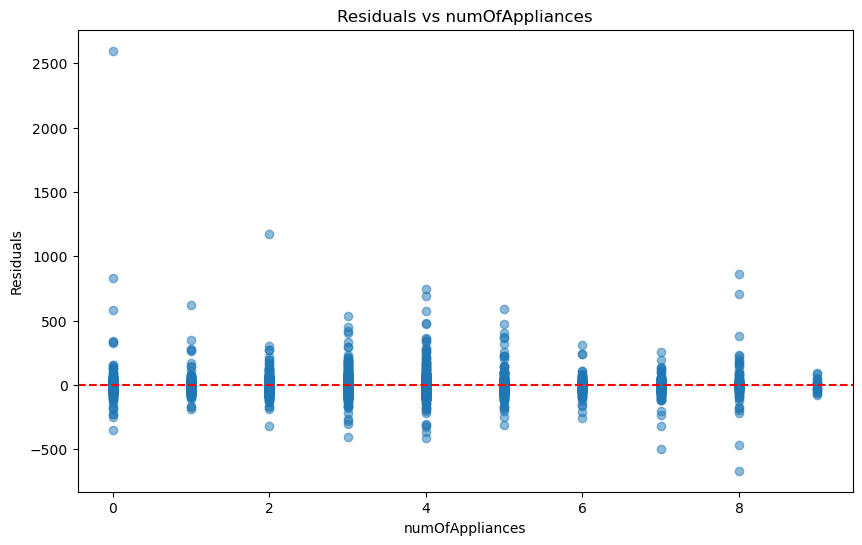

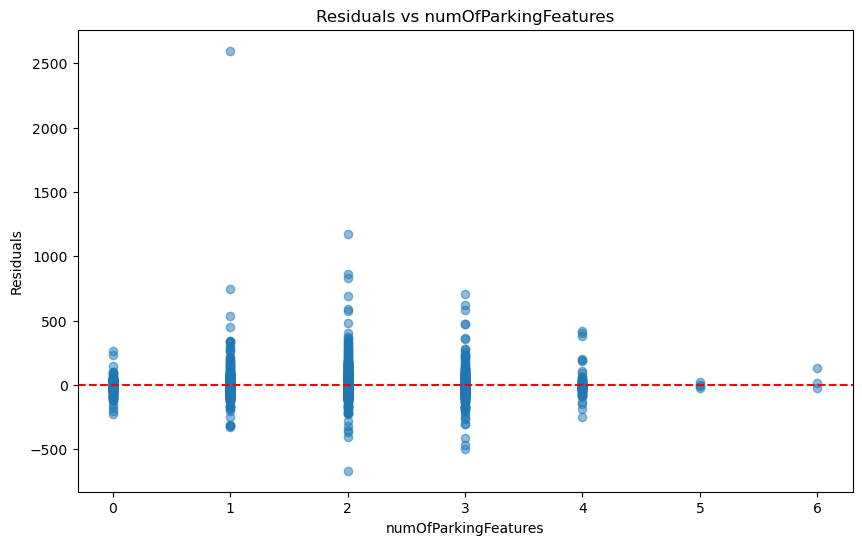

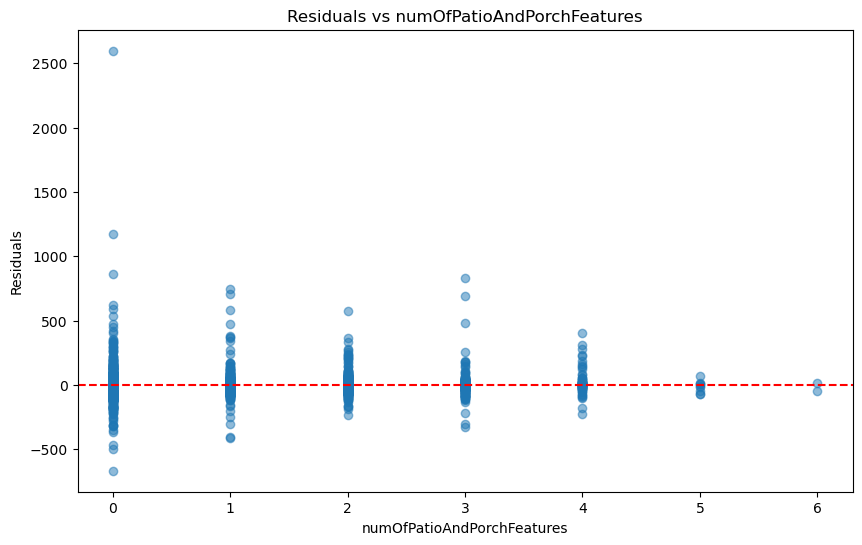

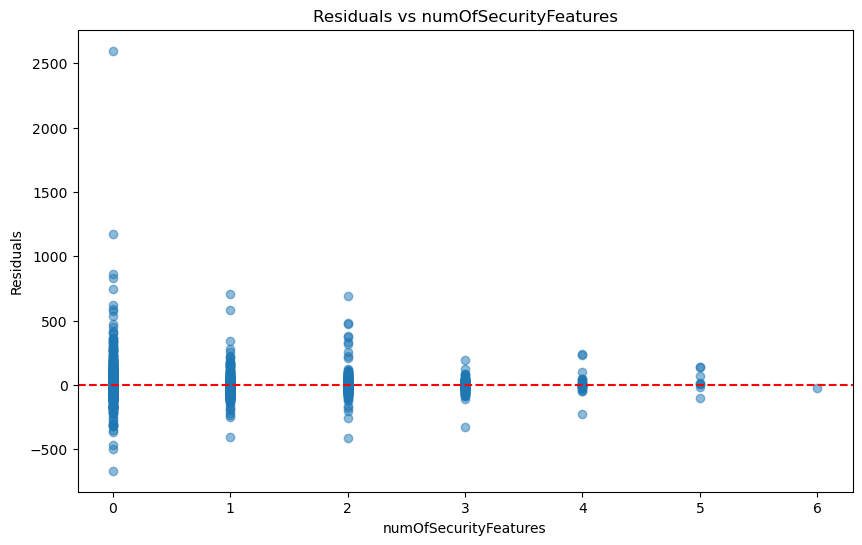

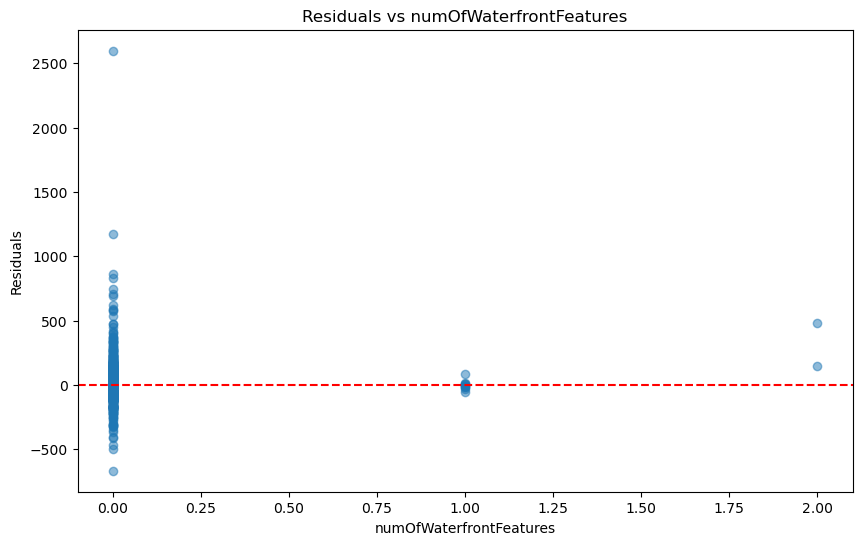

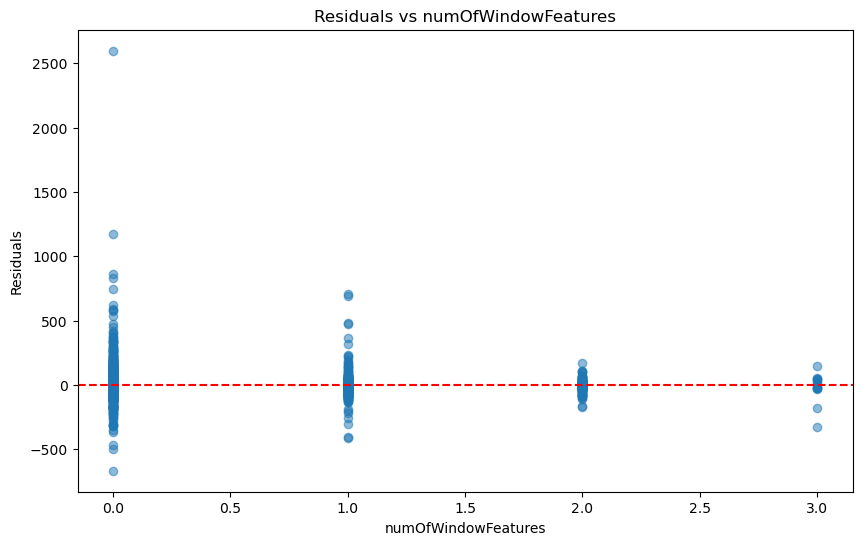

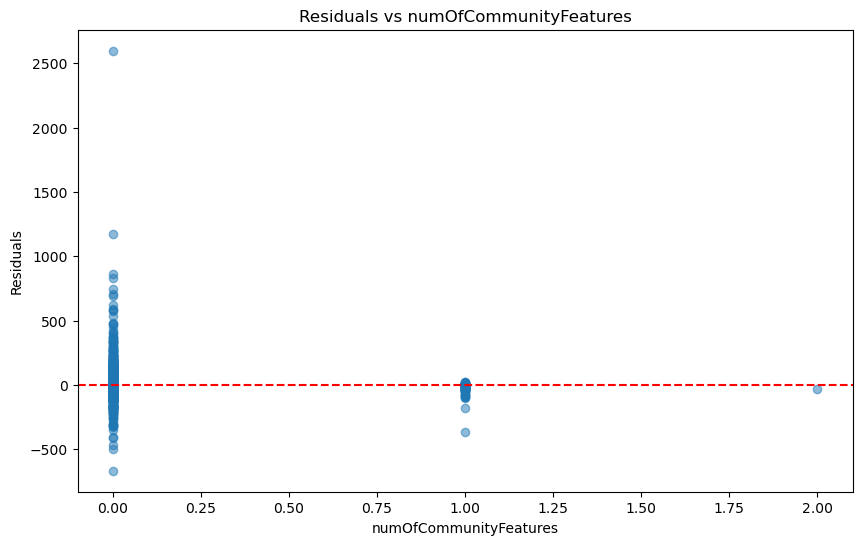

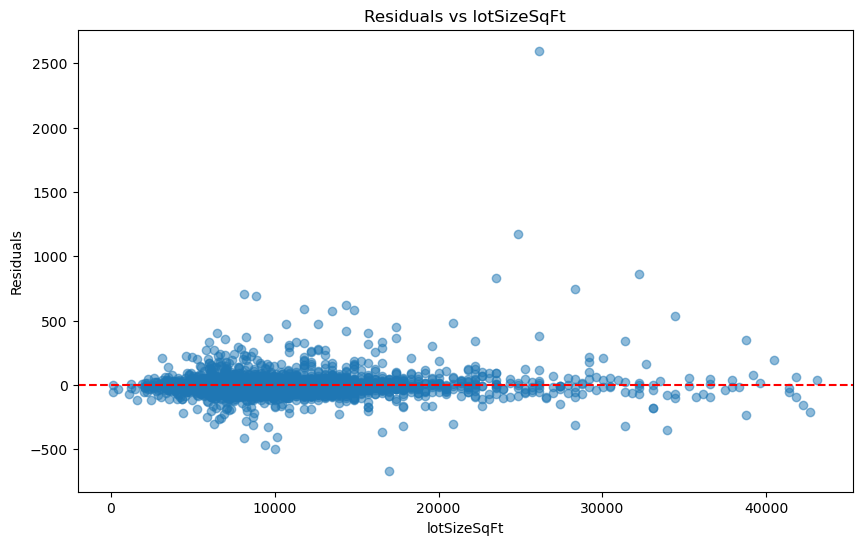

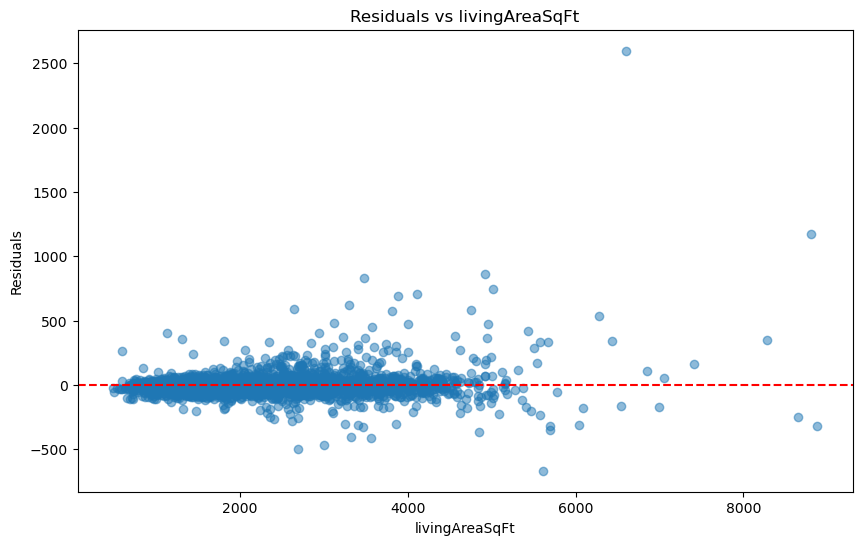

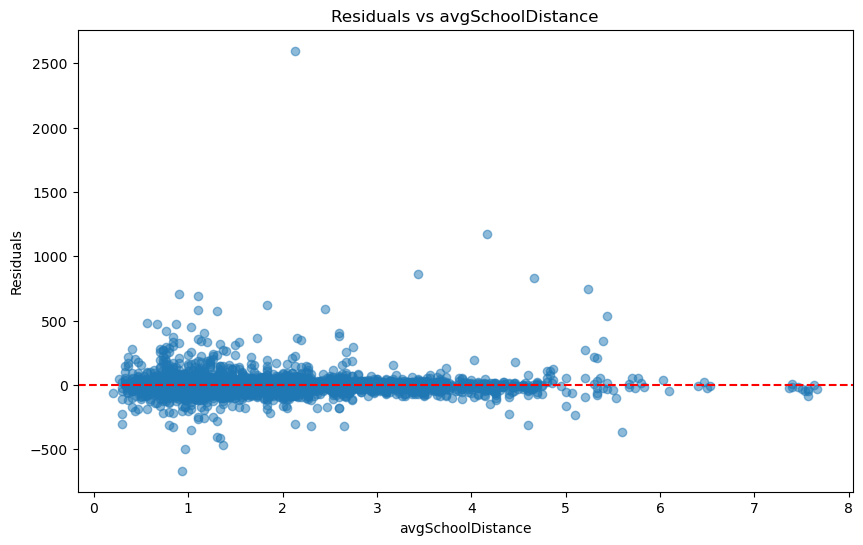

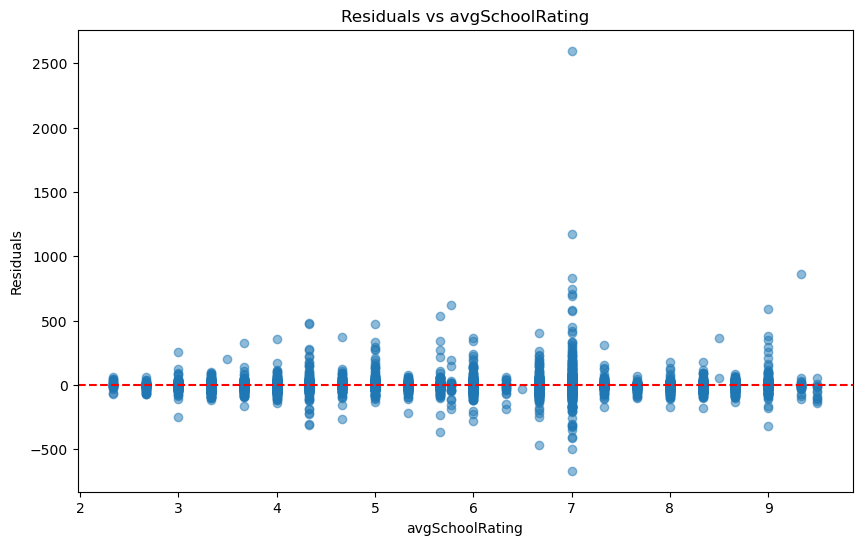

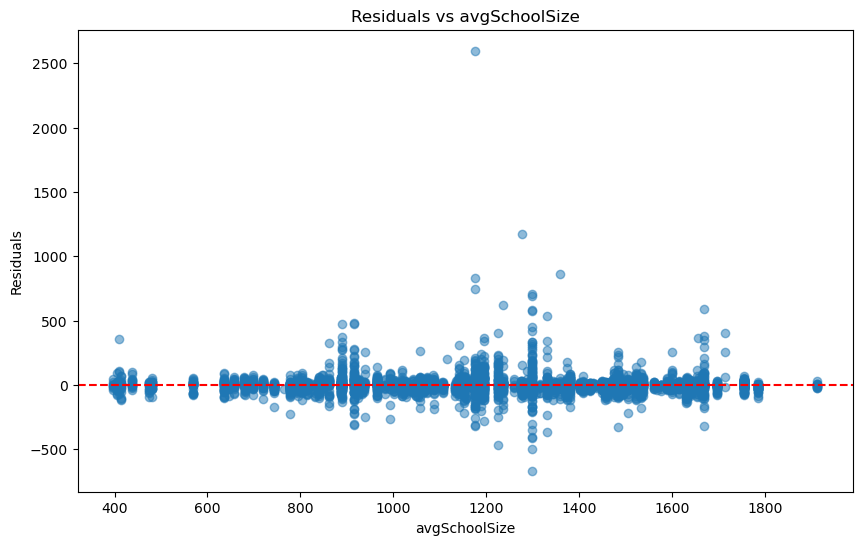

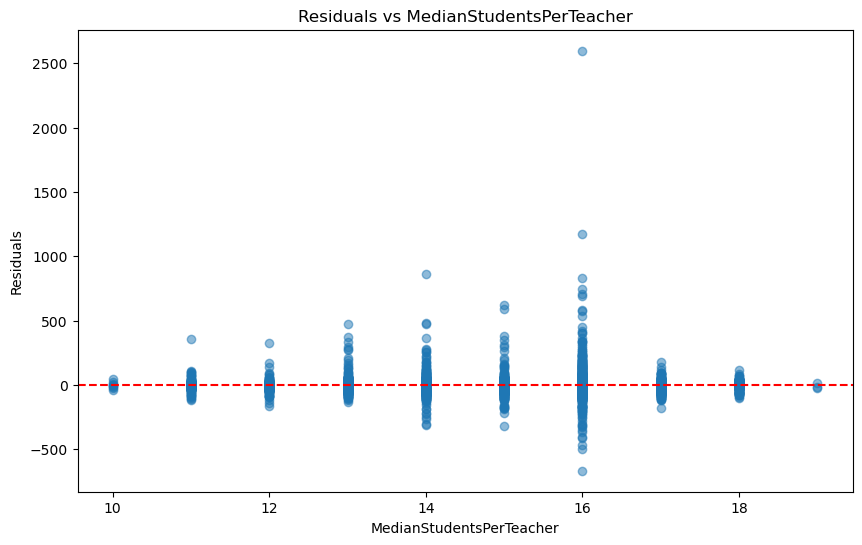

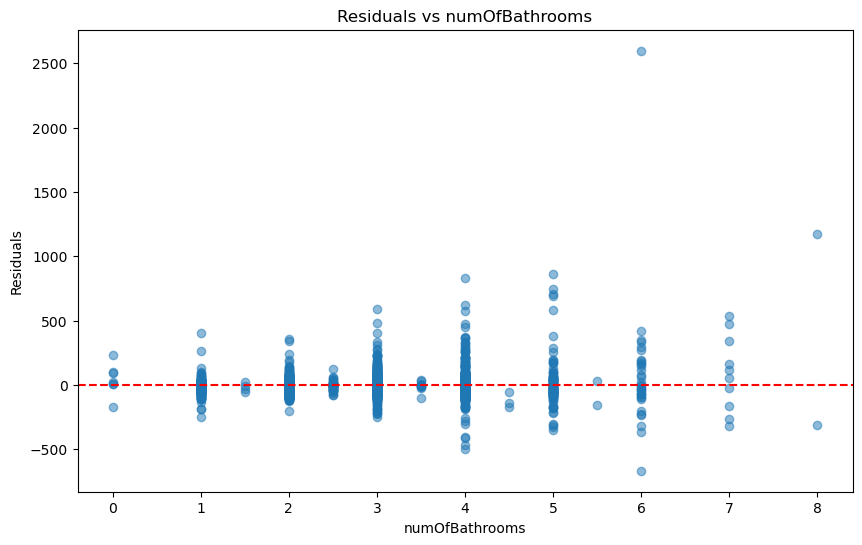

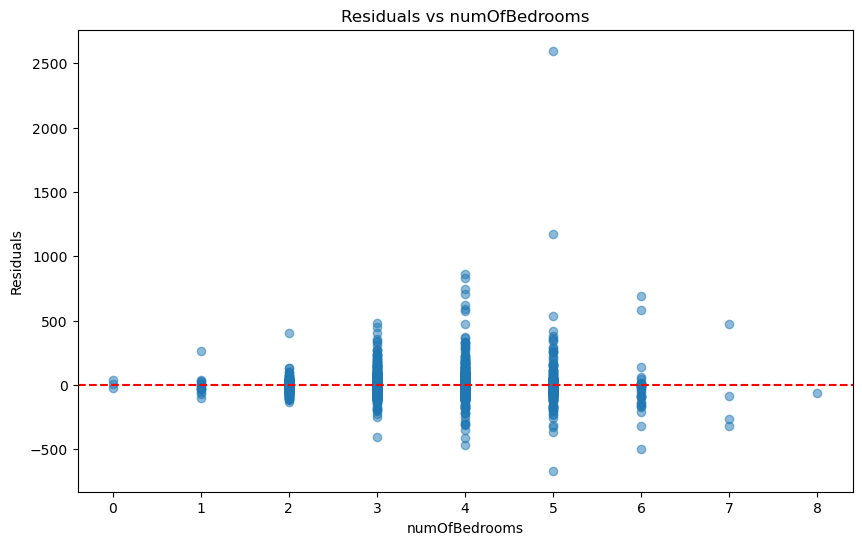

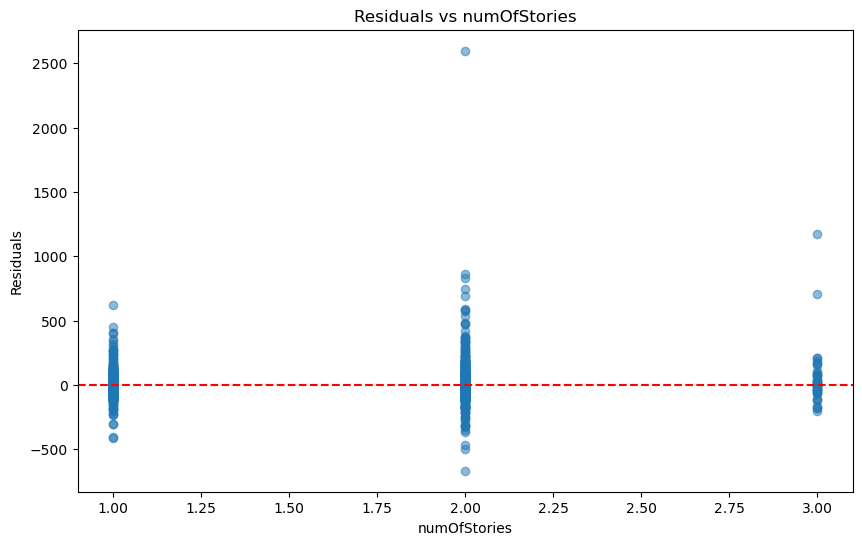

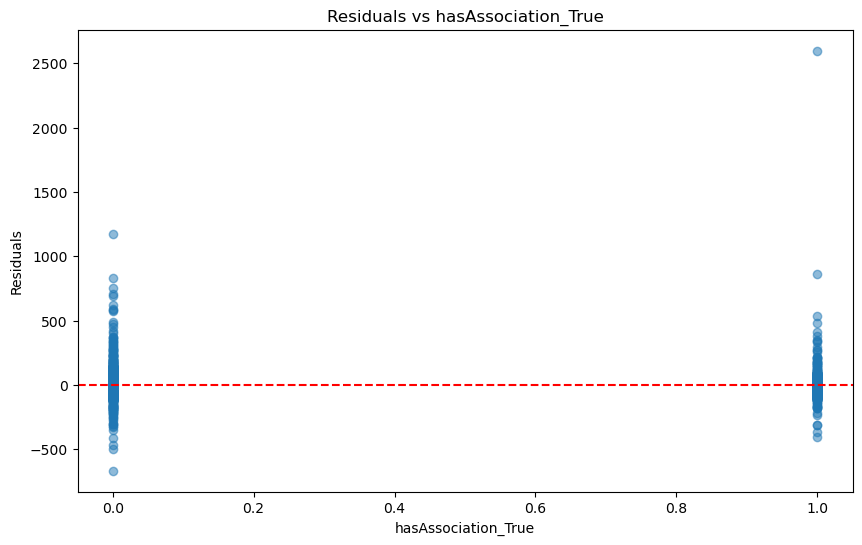

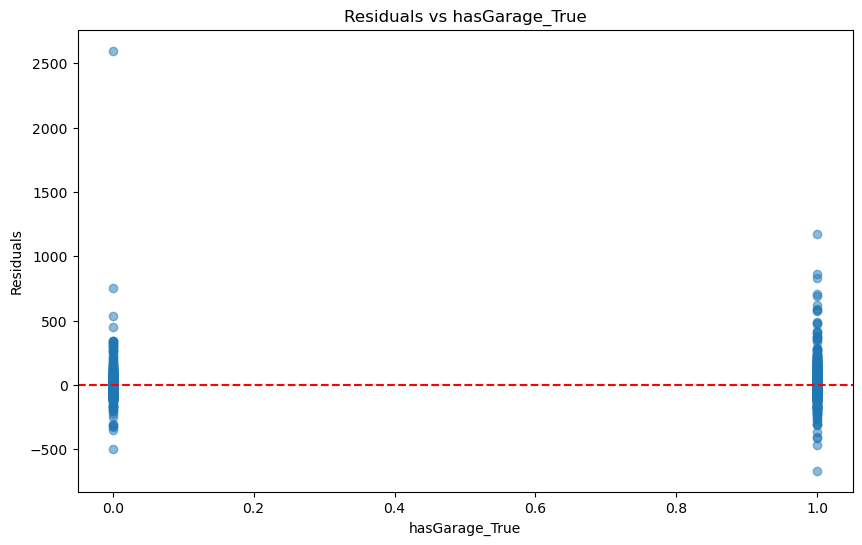

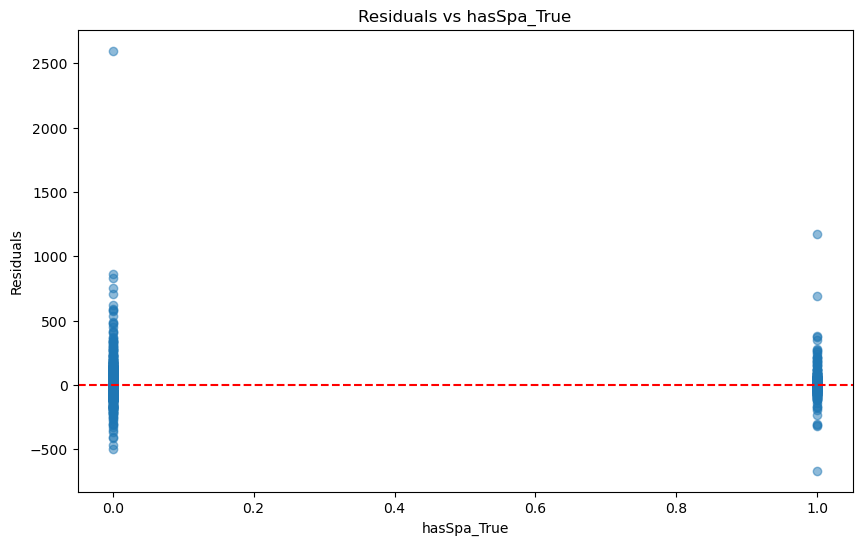

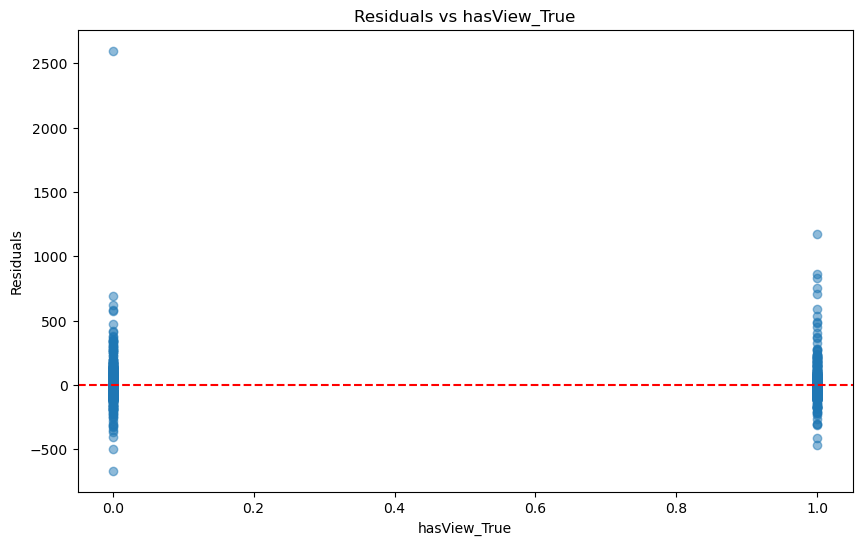

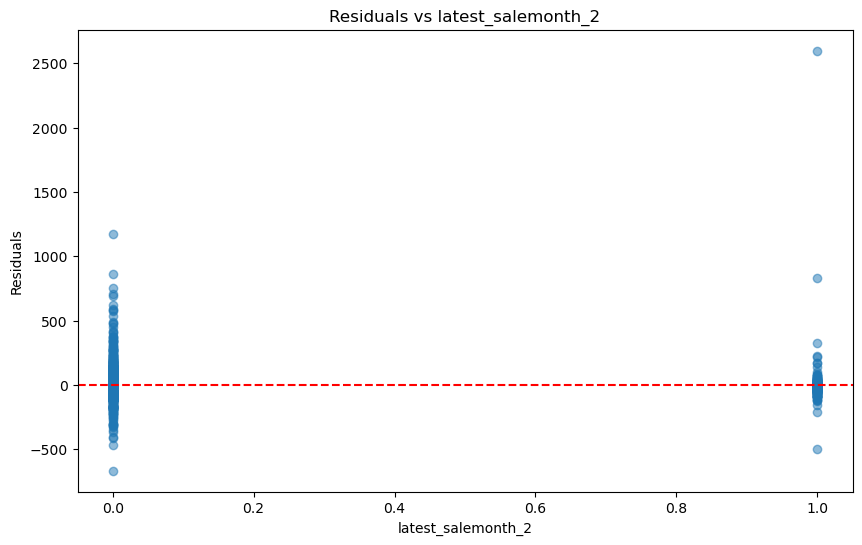

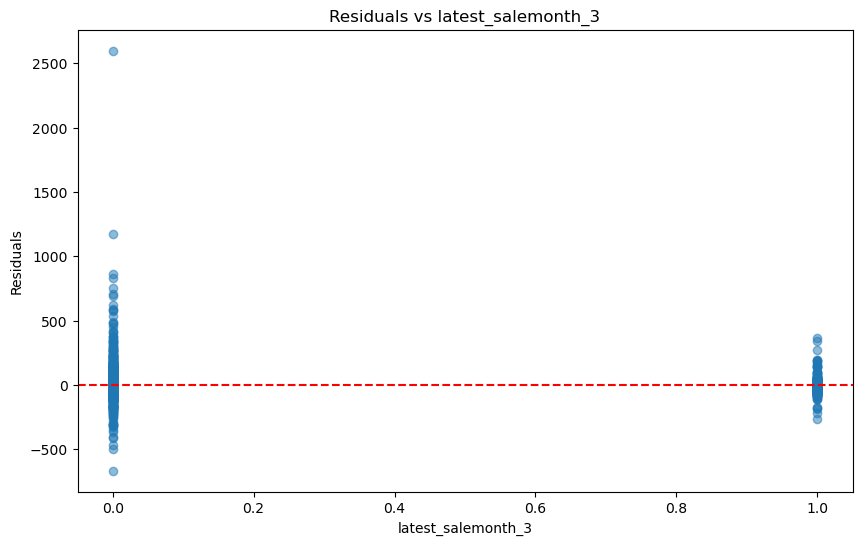

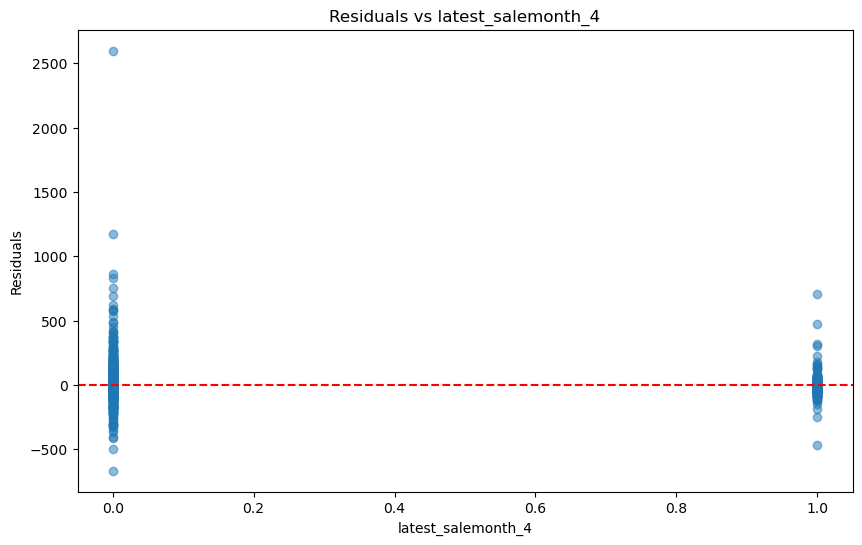

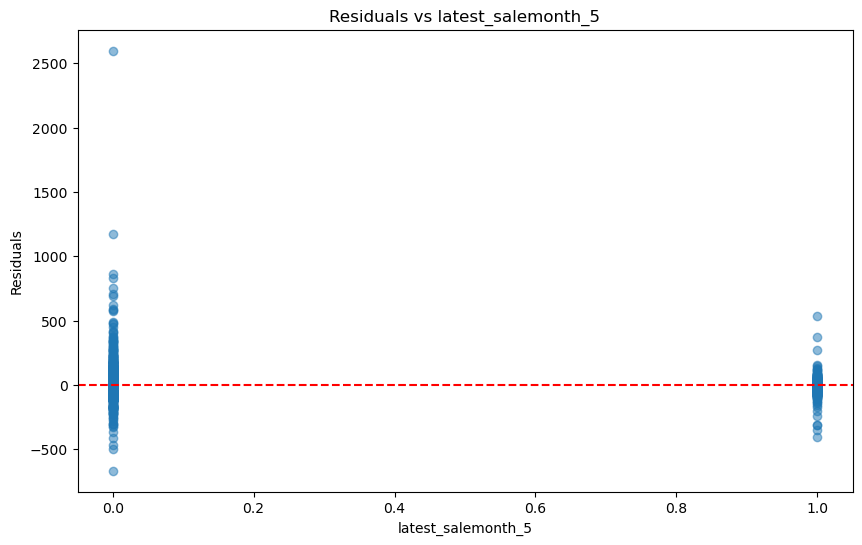

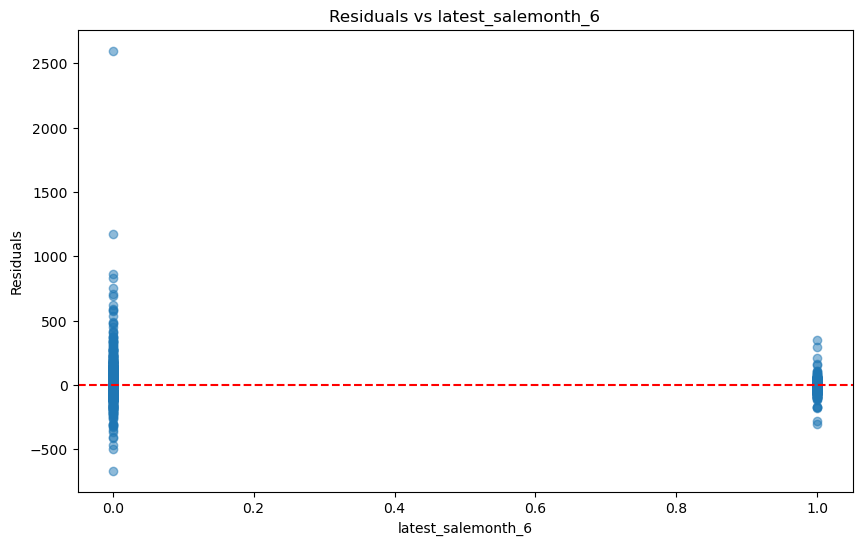

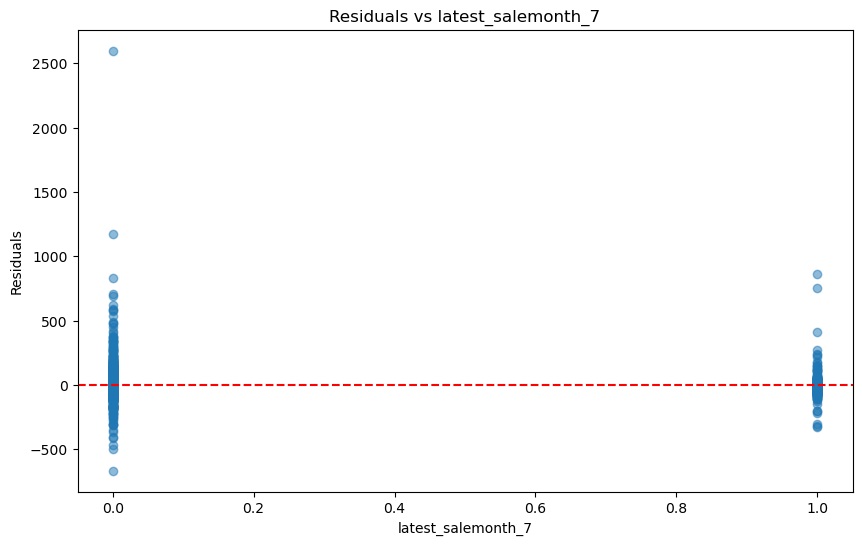

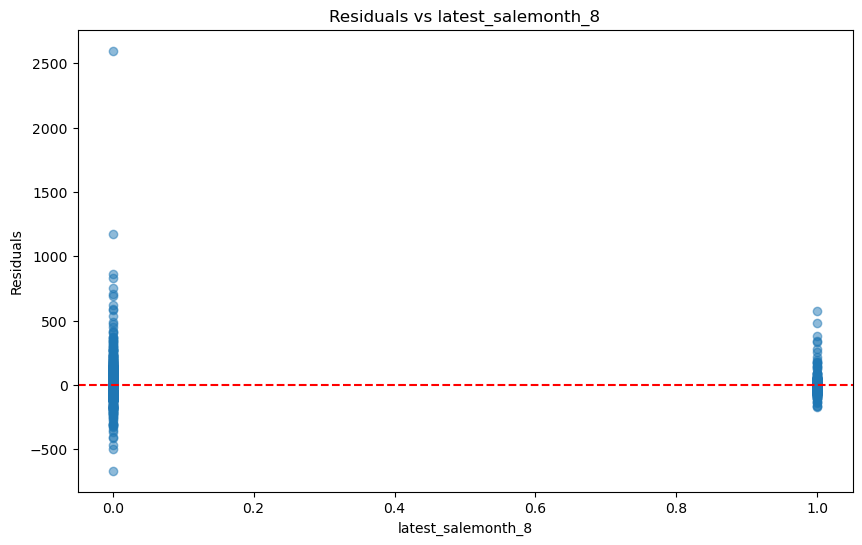

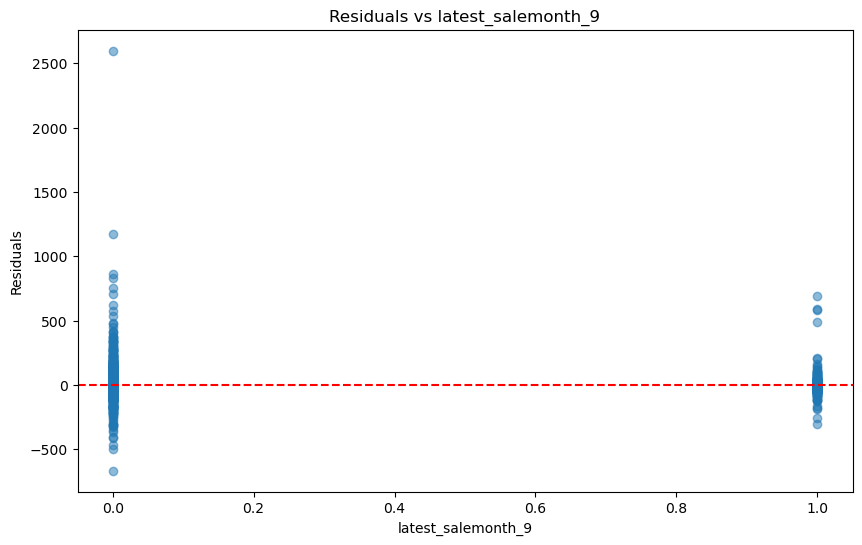

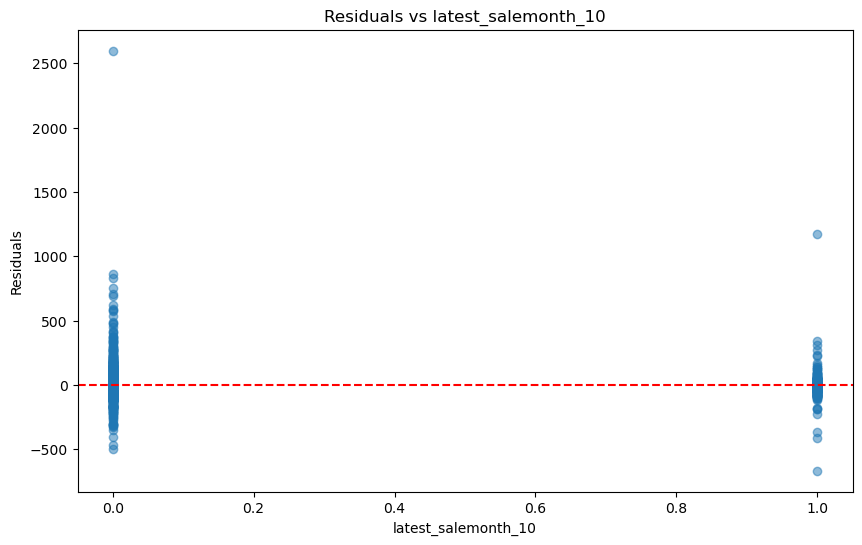

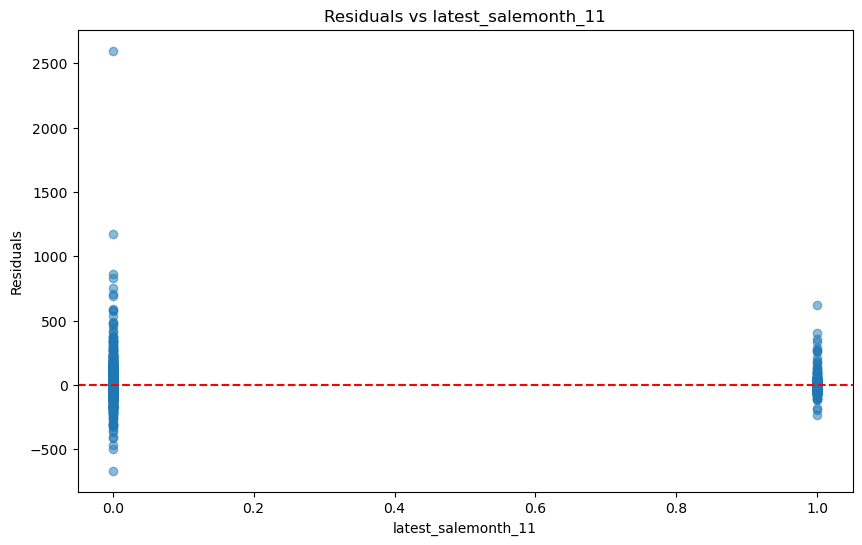

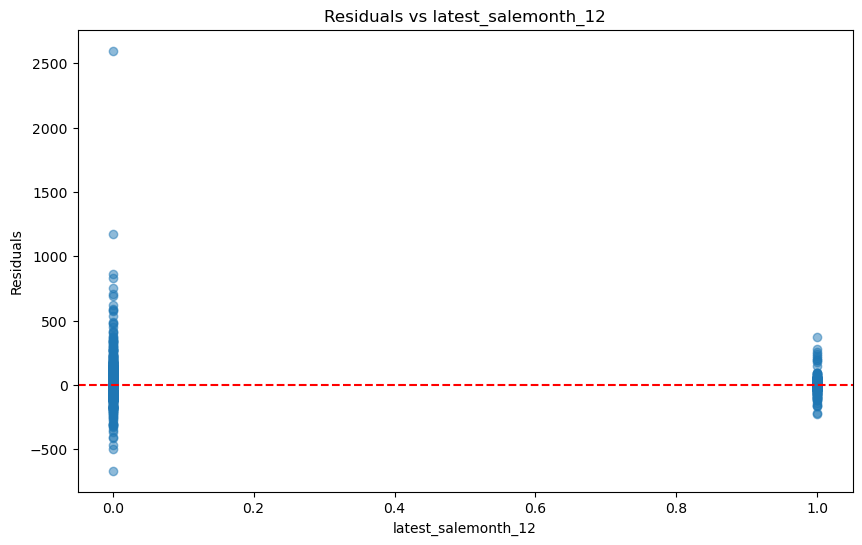

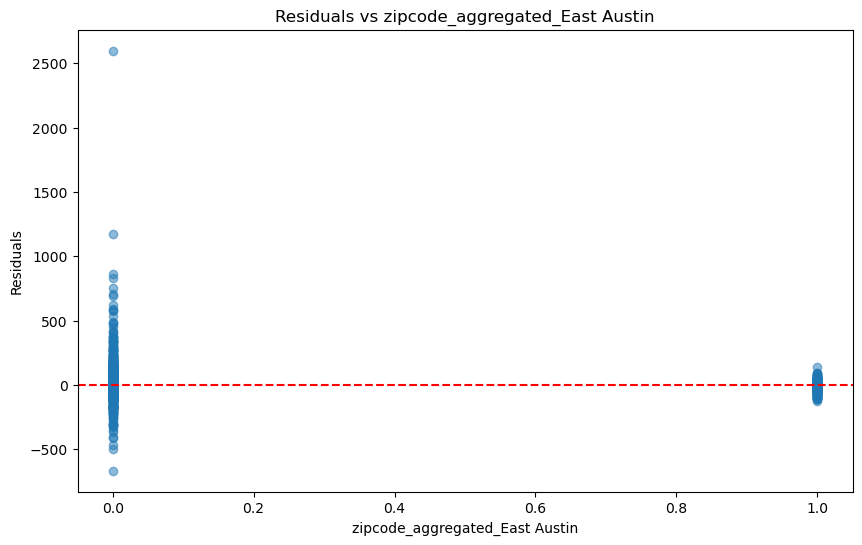

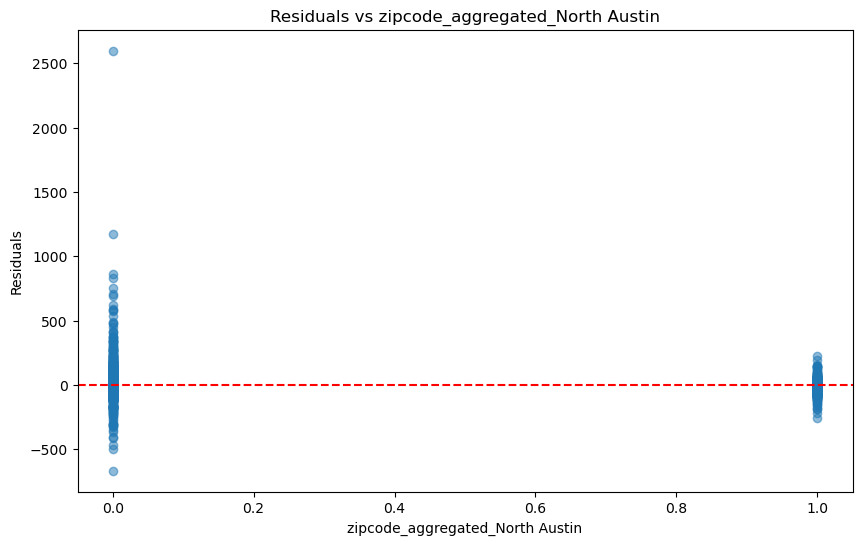

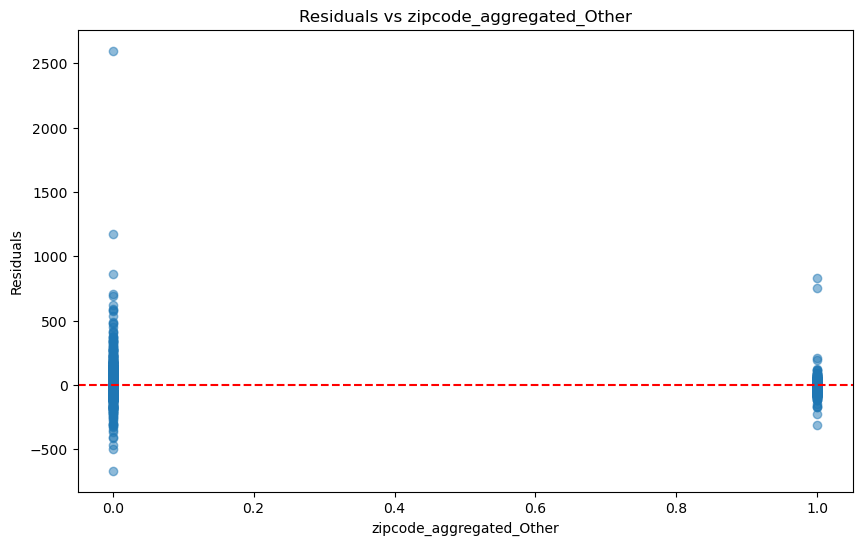

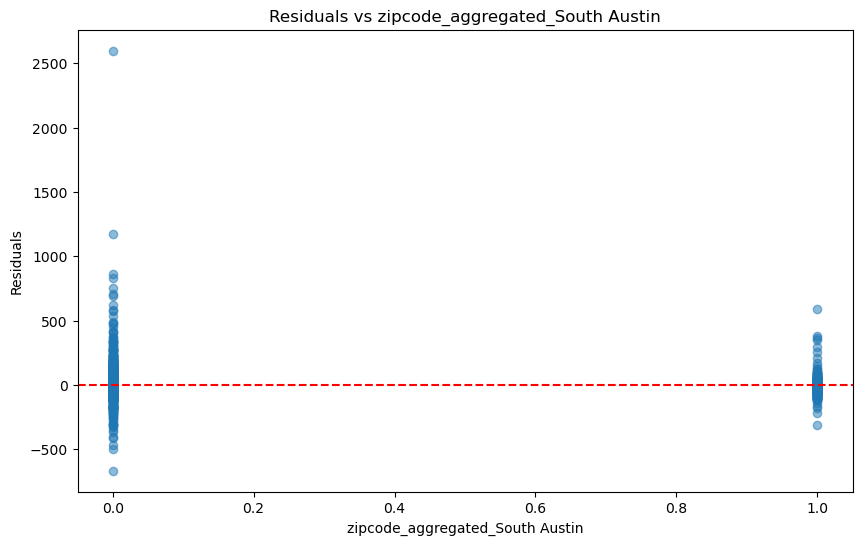

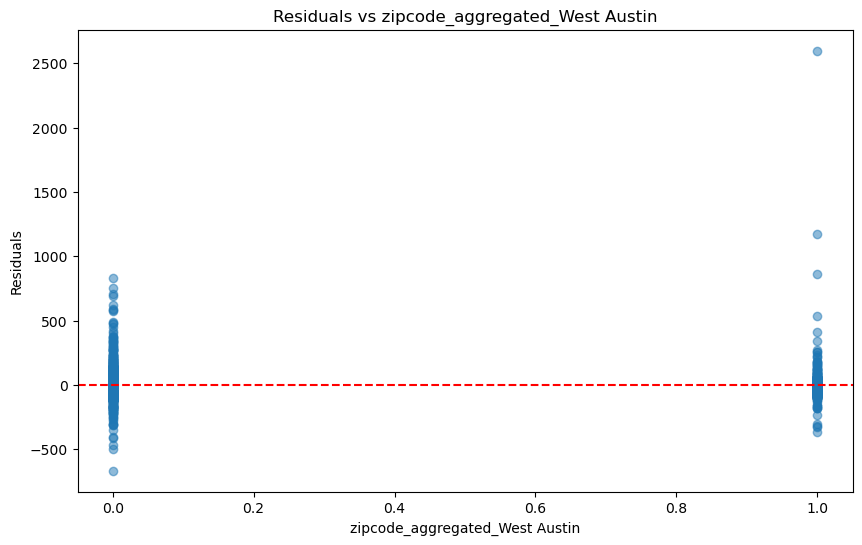

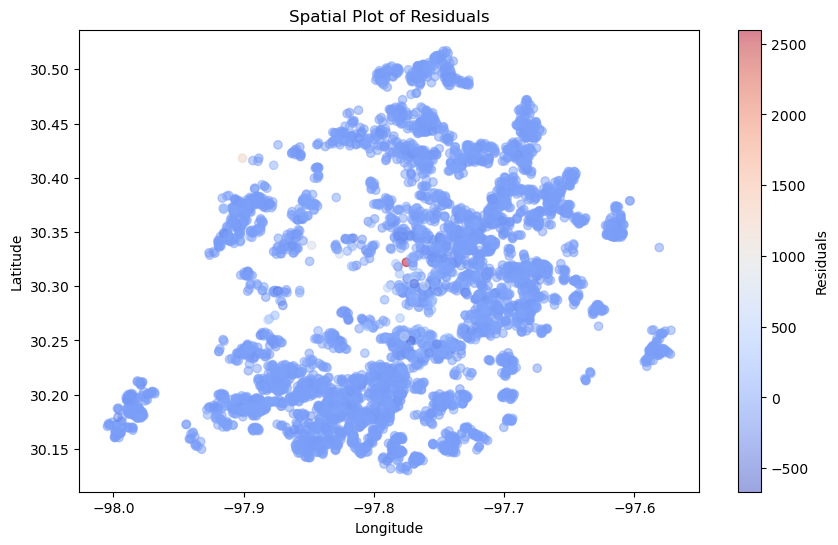

Important features for predicting residuals: ['latest_salemonth_2', 'livingAreaSqFt', 'numOfBathrooms', 'lotSizeSqFt', 'latitude']


In [279]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

model = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, n_estimators=200,
                               random_state=22, n_jobs=-1)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

residuals = y_train - y_train_pred

threshold = np.percentile(np.abs(residuals), 90)  # Top 10% largest errors
large_error_indices = np.where(np.abs(residuals) > threshold)[0]

large_error_cases = X_train.iloc[large_error_indices]
large_error_summary = pd.concat([large_error_cases, pd.Series(residuals.iloc[large_error_indices], index=large_error_indices, name='Residual')], axis=1)
print("Summary of large error cases:")
print(large_error_summary.describe())

for column in X_train.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[column], residuals, alpha=0.5)
    plt.title(f'Residuals vs {column}')
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

if 'latitude' in X_train.columns and 'longitude' in X_train.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train['longitude'], X_train['latitude'], c=residuals, cmap='coolwarm', alpha=0.5)
    plt.colorbar(label='Residuals')
    plt.title('Spatial Plot of Residuals')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

residual_tree = DecisionTreeRegressor(max_depth=3, random_state=22)
residual_tree.fit(X_train, residuals)

residual_importances = pd.Series(residual_tree.feature_importances_, index=X_train.columns)
important_features_for_residuals = residual_importances.nlargest(5).index.tolist()
print("Important features for predicting residuals:", important_features_for_residuals)